In [51]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import datetime as dt
import io, base64
import matplotlib.pyplot as plt
from utils.symbols import *
from utils.email_utils import *
from utils.corepath import *
from utils.formats import *
import pandas_datareader.data as web

In [52]:
# Load historical data for each ticker
def load_data(startdate, enddate, tickers, col=None):
    
    start_ts = pd.to_datetime(startdate)
    end_ts = pd.to_datetime(enddate)

    data = {}

    for t in tickers:
        csv_path = os.path.join(data_path, f"{t}.csv")
        if not os.path.exists(csv_path):
            print(f"[MISSING] {t}: CSV not found at {csv_path}")
            continue
        try:
            df = pd.read_csv(csv_path, parse_dates=["Date"])
            mask = (df["Date"] >= start_ts) & (df["Date"] <= end_ts)
            df = df.loc[mask].copy()
            if col:
                df = df.set_index("Date")
                df = df[col]
                df = df.rename(columns = {df.columns[0]: t})
            data[t] = df
            print(f"[LOADED] {t}: {len(df)} rows")
        except Exception as e:
            print(f"[ERR] {t}: failed to read {csv_path} ({e})")

    return data



In [53]:
def upsert_fred_csv(series_list, start, end, data_path, force_refresh=False):
    """
    Download FRED series and save to CSVs shaped like your loader expects:
    columns: Date, Close
    index: none (Date as a column)
    """
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)

    os.makedirs(data_path, exist_ok=True)

    for s in series_list:
        csv_path = os.path.join(data_path, f"{s}.csv")
        if os.path.exists(csv_path) and not force_refresh:
            print(f"[SKIP] {s}: CSV exists -> {csv_path}")
            continue

        print(f"[FRED] fetching {s} from {start.date()} to {end.date()}...")
        df = web.DataReader(s, "fred", start, end)  # returns a Series/DataFrame with date index
        # Normalize to your loader format
        df = df.reset_index().rename(columns={"DATE": "Date", s: "Close"})
        # Ensure dtypes are clean and sorted
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        # Optional: keep only business days and forward-fill (FRED misses holidays/weekends)
        # df = df.set_index("Date").asfreq("B").ffill().reset_index()

        df.to_csv(csv_path, index=False)
        print(f"[SAVED] {s}: {len(df)} rows -> {csv_path}")

In [235]:
# -------------------------------------------------
# 1) FOMC announcement dates (extend this list)
#    Use the *statement* (announcement) day.
# -------------------------------------------------

FOMC_EVENTS = pd.DataFrame([
    # === 2025 ===
    {"date": "2025-07-30", "decision": "Hold", "change_bps": 0,   "target_range": "4.25–4.50%"},
    {"date": "2025-06-18", "decision": "Hold", "change_bps": 0,   "target_range": "4.25–4.50%"},
    {"date": "2025-05-07", "decision": "Hold", "change_bps": 0,   "target_range": "4.25–4.50%"},
    {"date": "2025-03-19", "decision": "Hold", "change_bps": 0,   "target_range": "4.25–4.50%"},
    {"date": "2025-01-29", "decision": "Hold", "change_bps": 0,   "target_range": "4.25–4.50%"},

    # === 2024 ===
    {"date": "2024-12-18", "decision": "Cut",  "change_bps": -25, "target_range": "4.25–4.50%"},
    {"date": "2024-11-07", "decision": "Cut",  "change_bps": -25, "target_range": "4.50–4.75%"},
    {"date": "2024-09-18", "decision": "Cut",  "change_bps": -50, "target_range": "4.75–5.00%"},
    {"date": "2024-07-31", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2024-06-12", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2024-05-01", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2024-03-20", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2024-01-31", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},

    # === 2023 ===
#     {"date": "2023-12-13", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2023-11-01", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2023-09-20", "decision": "Hold", "change_bps": 0,   "target_range": "5.25–5.50%"},
#     {"date": "2023-07-26", "decision": "Hike", "change_bps": +25, "target_range": "5.25–5.50%"},
#     {"date": "2023-06-14", "decision": "Hold", "change_bps": 0,   "target_range": "5.00–5.25%"},
#     {"date": "2023-05-03", "decision": "Hike", "change_bps": +25, "target_range": "5.00–5.25%"},
#     {"date": "2023-03-22", "decision": "Hike", "change_bps": +25, "target_range": "4.75–5.00%"},
#     {"date": "2023-02-01", "decision": "Hike", "change_bps": +25, "target_range": "4.50–4.75%"},
])

FOMC_DATES = pd.to_datetime(FOMC_EVENTS["date"])
# FOMC_DATES = FOMC_EVENTS["date"].sort_values().to_list()

In [236]:
FOMC_EVENTS["date"] = pd.to_datetime(FOMC_EVENTS["date"])

In [237]:

# -------------------------------------------------
# 2) Parameters
# -------------------------------------------------
to_drop = {"FIG", "SPY", "TGT", "CRCL", "IBIT"}

tickers = [x for x in TICKERS if x not in to_drop]
# tickers = TICKERS
mkt = "SPY"                                 # market proxy for ARs
pre_days = 6
post_days = 4


In [238]:
# -----------------------------
# 3) Download prices
# -----------------------------
start = (FOMC_DATES.min() - pd.Timedelta(days=60)).strftime("%Y-%m-%d")
end   = (FOMC_DATES.max() + pd.Timedelta(days=60)).strftime("%Y-%m-%d")
all_tickers = list(set(tickers + [mkt]))

# px = yf.download(all_tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
px_dict = load_data(start, end, all_tickers, ['Close'])
px_df = pd.concat(px_dict.values(), axis=1)
px_df = px_df[px_df.index.dayofweek < 5]
rets = px_df.pct_change().dropna()



[LOADED] SMCI: 320 rows
[LOADED] NVDA: 320 rows
[LOADED] UBER: 320 rows
[LOADED] MSTR: 320 rows
[LOADED] BABA: 320 rows
[LOADED] XLP: 320 rows
[LOADED] TMF: 320 rows
[LOADED] SOXS: 320 rows
[LOADED] META: 320 rows
[LOADED] SHY: 319 rows
[LOADED] AI: 320 rows
[LOADED] WMT: 320 rows
[LOADED] XLY: 320 rows
[LOADED] XLE: 320 rows
[LOADED] MARA: 320 rows
[LOADED] VGK: 320 rows
[LOADED] VZ: 320 rows
[LOADED] EBAY: 320 rows
[LOADED] USO: 320 rows
[LOADED] TLT: 320 rows
[LOADED] T: 320 rows
[LOADED] YINN: 320 rows
[LOADED] COIN: 320 rows
[LOADED] AMD: 320 rows
[LOADED] SPXL: 320 rows
[LOADED] PLTR: 320 rows
[LOADED] MCHI: 320 rows
[LOADED] XRP-USD: 466 rows
[LOADED] INTC: 320 rows
[LOADED] ETH-USD: 451 rows
[LOADED] SHOP: 320 rows
[LOADED] XLF: 320 rows
[LOADED] CRSP: 320 rows
[LOADED] TSM: 320 rows
[LOADED] NKE: 320 rows
[LOADED] AMZN: 320 rows
[LOADED] OPEN: 320 rows
[LOADED] BTC-USD: 452 rows
[LOADED] GE: 320 rows
[LOADED] BILI: 320 rows
[LOADED] SPY: 320 rows
[LOADED] AAPL: 320 rows
[LOADE

In [239]:
rets

SMCI      NVDA      UBER      MSTR      BABA       XLP  \
Date                                                                     
2024-06-04  0.001324  0.012496  0.011914  0.006980  0.007060  0.008666   
2024-06-05  0.040059  0.051556  0.019675  0.034123  0.017591 -0.002180   
2024-06-06 -0.030653 -0.011777  0.046794 -0.022458  0.002255  0.003085   
2024-06-07 -0.011325 -0.000909  0.005951 -0.036478 -0.019997 -0.004997   
2024-06-10  0.023079  0.007461 -0.010244  0.002331  0.011351 -0.000773   
...              ...       ...       ...       ...       ...       ...   
2025-09-05 -0.007125 -0.027030 -0.010763  0.025275  0.035594  0.002852   
2025-09-08 -0.009156  0.007724  0.037037 -0.017775  0.041452 -0.003710   
2025-09-09  0.071928  0.014556  0.011551 -0.004153  0.041785  0.001986   
2025-09-10  0.023066  0.038475 -0.012991 -0.006331 -0.021550 -0.009786   
2025-09-11  0.000911 -0.000902  0.004989 -0.001317  0.079970  0.008131   

                 TMF      SOXS      META       SHY  ...      JNUG      SOXL  \
Date                                                ...                       
2024-06-04  0.034931  0.024488 -0.001047  0.000984  ... -0.083448 -0.020580   
2024-06-05  0.021782 -0.130218  0.037883  0.000983  ...  0.044400  0.124606   
2024-06-06 -0.003265  0.023380 -0.002626  0.000123  ...  0.051349 -0.018871   
2024-06-07 -0.056262  0.010020 -0.001620 -0.002578  ... -0.144480 -0.012188   
2024-06-10 -0.020621 -0.042460  0.019555  0.000123  ...  0.015135  0.040100   
...              ...       ...       ...       ...  ...       ...       ...   
2025-09-05  0.045407 -0.030471  0.005076  0.001449  ...  0.051476  0.031189   
2025-09-08  0.038915 -0.021429 -0.000199  0.000603  ...  0.036820  0.023818   
2025-09-09 -0.016675 -0.002920  0.017812  0.000000  ... -0.018393  0.003693   
2025-09-10  0.018186 -0.052709 -0.017918 -0.000723  ...  0.057674  0.052244   
2025-09-11  0.017620 -0.018547 -0.001436  0.000362  ...  0.043868  0.019930   

                 QQQ       SMR      SOFI     GOOGL      HOOD      COST  \
Date                                                                     
2024-06-04  0.002736 -0.085190 -0.007386  0.003580 -0.023496  0.014717   
2024-06-05  0.020160  0.116046  0.028274  0.009322  0.038017  0.008352   
2024-06-06 -0.000345 -0.015404  0.024602  0.007525  0.064905  0.009996   
2024-06-07 -0.000885  0.053455 -0.012712 -0.012844 -0.034393  0.003489   
2024-06-10  0.004039  0.074257  0.005723  0.003153  0.055906  0.003264   
...              ...       ...       ...       ...       ...       ...   
2025-09-05  0.001443 -0.041632  0.008668  0.011623 -0.016131  0.007930   
2025-09-08  0.004878 -0.016797  0.014062 -0.004085  0.158321  0.008687   
2025-09-09  0.002833  0.040943  0.000385  0.023885  0.010402  0.007614   
2025-09-10  0.000327 -0.029145 -0.017328 -0.001920 -0.008776 -0.023447   
2025-09-11  0.005821  0.025357  0.017241  0.005017  0.002469  0.008397   

                 JNJ      TSLA  
Date                            
2024-06-04  0.000406 -0.008622  
2024-06-05 -0.012382  0.001316  
2024-06-06  0.003083  0.016800  
2024-06-07  0.004508 -0.002585  
2024-06-10  0.000340 -0.020791  
...              ...       ...  
2025-09-05 -0.001846  0.036363  
2025-09-08 -0.001681 -0.012655  
2025-09-09 -0.006568  0.001646  
2025-09-10 -0.006612  0.002363  
2025-09-11  0.015416  0.060439  

[333 rows x 74 columns]

In [240]:
# -----------------------------
# 4) Build event windows
# -----------------------------
def get_window(df, event_date, pre=pre_days, post=post_days):
    # Use nearest trading day on/after the given date for event day (E0)
    if event_date not in df.index:
        try:
            event_date = df.index[df.index.get_indexer([event_date], method="bfill")[0]]
        except Exception:
            return None, None
    e0_loc = df.index.get_loc(event_date)
    start_loc = max(0, e0_loc - pre)
    end_loc   = min(len(df.index)-1, e0_loc + post)
    window = df.iloc[start_loc:end_loc+1].copy()
    rel_days = np.arange(start_loc - e0_loc, end_loc - e0_loc + 1)
    window["rel_day"] = rel_days
    return window, event_date


In [241]:
# -------------------------------------------------
# 5A) Event study for equities (AR & CAR vs market)
# -------------------------------------------------
def event_study_equities(rets, tickers, mkt, dates, pre=pre_days, post=post_days):
    rows = []
    curves = {}
    for d in dates:
        win, e0 = get_window(rets, d, pre, post)
        if win is None:
            continue

        # event-day market return (signal sign proxy)
        mkt_e0_ret = win.loc[win["rel_day"]==0, mkt].values[0]

        for t in tickers:
            w = win[[t, mkt, "rel_day"]].dropna().copy()
            w["AR"] = w[t] - w[mkt]
            w["CAR"] = w["AR"].cumsum()

            def car_window(lo, hi):
                return w.loc[(w["rel_day"]>=lo)&(w["rel_day"]<=hi), "AR"].sum()

            mask_3d = (w["rel_day"]>=-1)&(w["rel_day"]<=1)
            tstat, pval = stats.ttest_1samp(w.loc[mask_3d,"AR"], 0.0, nan_policy="omit")

            rows.append({
                "kind": "equity",
                "ticker": t,
                "event_date": pd.to_datetime(e0).date(),
                "mkt_event_ret": mkt_e0_ret,
                "AR_E0": w.loc[w["rel_day"]==0, "AR"].values[0],
                "CAR_-1_to_+1": car_window(-1, +1),
                "CAR_-3_to_+3": car_window(-3, +3),
                "AR_tstat_-1_to_+1": tstat,
                "AR_pval_-1_to_+1": pval,
                "signal": np.sign(mkt_e0_ret)  # +1 stocks up, -1 down
            })

            curves[(t, str(e0.date()))] = w[["rel_day","CAR"]].set_index("rel_day")["CAR"]

    out = pd.DataFrame(rows).sort_values(["ticker","event_date"])
    return out, curves


In [242]:
# -------------------------------------------------
# 5B) Event study for yields (2y & 30y)
#     We use *level changes in bps* and cumulative changes (CBC = cum bp change).
# -------------------------------------------------
def event_study_yields(yld_levels, dates, pre=pre_days, post=post_days):
    """
    yld_levels: DataFrame with columns ['DGS2','DGS30'] as levels (%)
    Returns per-event rows and per-event curves of cumulative bp changes.
    """
    rows = []
    curves = {}
    y = yld_levels.copy().dropna(subset=["DGS2","DGS30"])
    # daily bp change
    dy = y.diff() * 100.0  # % to bps

    for d in dates:
        win_lvl, e0 = get_window(y, d, pre, post)
        win_bp, _   = get_window(dy, d, pre, post)
        if win_lvl is None or win_bp is None:
            continue

        w = win_bp[["DGS2","DGS30","rel_day"]].dropna().copy()
        w["CBC_2y"]  = w["DGS2"].cumsum()
        w["CBC_30y"] = w["DGS30"].cumsum()

        # summarize windows
        def sum_window(col, lo, hi):
            return w.loc[(w["rel_day"]>=lo)&(w["rel_day"]<=hi), col].sum()

        rows.append({
            "kind": "yields",
            "ticker": "DGS2",
            "event_date": pd.to_datetime(e0).date(),
            "bp_E0": w.loc[w["rel_day"]==0, "DGS2"].values[0],
            "bp_-1_to_+1": sum_window("DGS2", -1, +1),
            "bp_-3_to_+3": sum_window("DGS2", -3, +3),
        })
        rows.append({
            "kind": "yields",
            "ticker": "DGS30",
            "event_date": pd.to_datetime(e0).date(),
            "bp_E0": w.loc[w["rel_day"]==0, "DGS30"].values[0],
            "bp_-1_to_+1": sum_window("DGS30", -1, +1),
            "bp_-3_to_+3": sum_window("DGS30", -3, +3),
        })

        # store per-event cumulative curves
        curves[("DGS2", str(e0.date()))]  = w[["rel_day","CBC_2y"]].set_index("rel_day")["CBC_2y"]
        curves[("DGS30", str(e0.date()))] = w[["rel_day","CBC_30y"]].set_index("rel_day")["CBC_30y"]

    out = pd.DataFrame(rows).sort_values(["ticker","event_date"])
    return out, curves


In [243]:
# -------------------------------------------------
# 6) Run
# -------------------------------------------------
start = (FOMC_DATES.min() - pd.Timedelta(days=90)).strftime("%Y-%m-%d")
end   = (FOMC_DATES.max() + pd.Timedelta(days=90)).strftime("%Y-%m-%d")
eq_results, eq_curves = event_study_equities(rets, tickers, mkt, FOMC_DATES, pre_days, post_days)


In [244]:
eq_results["event_date"] = pd.to_datetime(eq_results["event_date"])
eq_results = eq_results.merge(
    FOMC_EVENTS[["date","decision","change_bps"]],
    left_on="event_date", right_on="date", how="left"
).drop(columns=["date"])

In [245]:
eq_results

kind ticker event_date  mkt_event_ret     AR_E0  CAR_-1_to_+1  \
0    equity   AAPL 2024-07-31       0.016255 -0.001264      0.003779   
1    equity   AAPL 2024-09-18      -0.002966  0.020956      0.042721   
2    equity   AAPL 2024-11-07       0.007732  0.013640     -0.021110   
3    equity   AAPL 2024-12-18      -0.029803  0.008382      0.029543   
4    equity   AAPL 2025-01-29      -0.004483  0.009100      0.024289   
..      ...    ...        ...            ...       ...           ...   
670  equity   YINN 2025-01-29      -0.004483 -0.005340      0.078420   
671  equity   YINN 2025-03-19       0.010891 -0.023738     -0.100304   
672  equity   YINN 2025-05-07       0.004206 -0.069363      0.005283   
673  equity   YINN 2025-06-18      -0.000151 -0.039970     -0.063228   
674  equity   YINN 2025-07-30      -0.001259 -0.029860     -0.074938   

     CAR_-3_to_+3  AR_tstat_-1_to_+1  AR_pval_-1_to_+1  signal decision  \
0        0.001882           0.392493          0.732574     1.0     Hold   
1       -0.001192           2.280559          0.150142    -1.0      Cut   
2       -0.038474          -0.583451          0.618620     1.0      Cut   
3        0.045161           4.876856          0.039567    -1.0      Cut   
4        0.040703           0.688264          0.562397    -1.0     Hold   
..            ...                ...               ...     ...      ...   
670      0.129487           1.407518          0.294573    -1.0     Hold   
671     -0.036646          -1.252658          0.336944     1.0     Hold   
672      0.148185           0.049465          0.965044     1.0     Hold   
673     -0.051179          -1.818514          0.210609    -1.0     Hold   
674     -0.112262          -7.429776          0.017638    -1.0     Hold   

     change_bps  
0             0  
1           -50  
2           -25  
3           -25  
4             0  
..          ...  
670           0  
671           0  
672           0  
673           0  
674           0  

[675 rows x 12 columns]

In [246]:
# -------------------------------------------------
# 7) Summaries (average across events)
# -------------------------------------------------
# Equities: mean CAR windows
eq_summary = (eq_results.groupby("ticker")[["CAR_-1_to_+1","CAR_-3_to_+3"]]
              .mean().rename(columns=lambda c: c+"_avg"))


In [247]:
# Share of significant ±1d AR (p<0.05)
eq_sig_share = (eq_results.groupby("ticker")["AR_pval_-1_to_+1"]
                .apply(lambda s: (s<0.05).mean())
                .rename("share_sig_events(±1d_AR)"))
eq_final_summary = eq_summary.join(eq_sig_share).round(4)
eq_final_summary

CAR_-1_to_+1_avg  CAR_-3_to_+3_avg  share_sig_events(±1d_AR)
ticker                                                               
AAPL               0.0055           -0.0022                    0.1111
AI                -0.0193           -0.0131                    0.1111
AMD                0.0051            0.0338                    0.0000
AMZN               0.0044           -0.0056                    0.0000
BABA              -0.0002            0.0071                    0.0000
...                   ...               ...                       ...
XLY               -0.0000            0.0097                    0.2222
XOM                0.0076            0.0024                    0.2222
XRP-USD            0.0075            0.0185                    0.0000
YANG               0.0162           -0.0232                    0.1111
YINN              -0.0173            0.0080                    0.1111

[73 rows x 3 columns]

In [248]:
def mean_curve(curves_dict, key_ticker):
    ser = [s for (tk, _), s in curves_dict.items() if tk==key_ticker]
    if not ser:
        return None
    return pd.concat(ser, axis=1).mean(axis=1)  # index = rel_day


In [249]:
mean_car_NVDA = mean_curve(eq_curves, "NVDA")
mean_car_TGT  = mean_curve(eq_curves, "TGT")
mean_car_AMZN = mean_curve(eq_curves, "AMZN")

In [250]:

# -------------------------------------------------
# 9) Quick display helpers (optional)
# -------------------------------------------------
def _fig_to_base64(fig):
    import io, base64
    buf = io.BytesIO(); fig.savefig(buf, format="png", bbox_inches="tight", dpi=160); plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")


In [251]:
def plot_mean_equity_car(ticker, s):
    if s is None: return None
    s = s.sort_index()
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    ax.plot(s.index, s.values, marker="o")
    ax.axvline(0, linestyle="--")
    ax.set_title(f"{ticker} — Mean CAR (FOMC, -{pre_days}d to {post_days}d)")
    ax.set_xlabel("rel_day (E0 = FOMC ann.)")
    ax.set_ylabel("Mean CAR")
#     return _fig_to_base64(fig)
    return fig


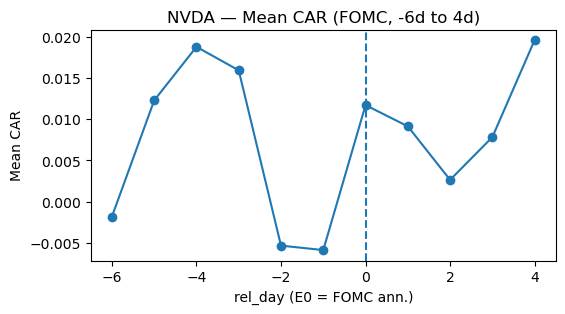

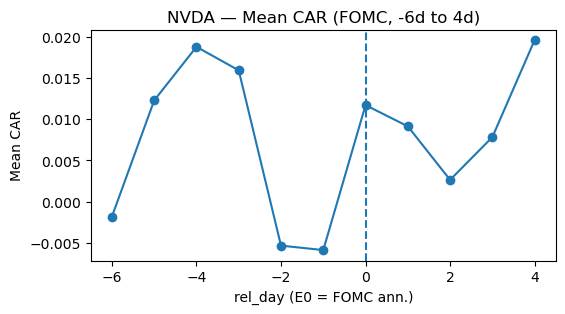

In [252]:
plot_mean_equity_car('NVDA', mean_car_NVDA)

In [265]:
def plot_each_event_overlaid(curves_dict, ticker, events_df=None,
                             title=None, linewidth=1, alpha=0.6, figsize=(10,4)):
    """
    Plot all event curves for a ticker, highlight the most recent event (nearest in time).
    curves_dict: {(ticker, 'YYYY-MM-DD'): Series}
    events_df: optional DataFrame with ['date','decision','change_bps']
    """
    series_list = [(k, s.sort_index()) for k, s in curves_dict.items() if k[0] == ticker]
    if not series_list:
        print(f"[plot_each_event_overlaid] No curves for {ticker}")
        return

    # Find the latest/nearest event
    event_dates = [pd.to_datetime(evdate) for (_, evdate), _ in series_list]
    latest_date = max(event_dates) if event_dates else None

    fig, ax = plt.subplots(figsize=figsize)
    for (tk, evdate), s in series_list:
        ev_ts = pd.to_datetime(evdate).normalize()

        # build legend label
        label = str(ev_ts.date())
        if events_df is not None:
            row = events_df.loc[events_df["date"] == ev_ts]
            if not row.empty:
                decision = row["decision"].values[0]
                bps = row["change_bps"].values[0]
                label = f"{ev_ts.date()} ({decision} {bps:+}bp)"

        # make the latest event bold
        if decision == 'Cut':
            lw = linewidth * 2.4
            alp = 1.0
            zorder = 3
        else:
            lw = linewidth
            alp = alpha
            zorder = 1

        ax.plot(s.index, s.values, marker="o", linewidth=lw, alpha=alp, label=label, zorder=zorder)

    ax.axvline(0, linestyle="--")
    ax.set_xlabel("rel_day (E0 = FOMC ann.)")
    ax.set_ylabel("CAR" if ticker in ["NVDA","AMZN","TGT","SPY"] else "Cum. bp change")
    ax.set_title(title or f"{ticker}: per-event curves (-3..+3)")

    # Legend outside on the right
    ax.legend(
        title="Event",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.
    )

    plt.tight_layout()
    plt.show()


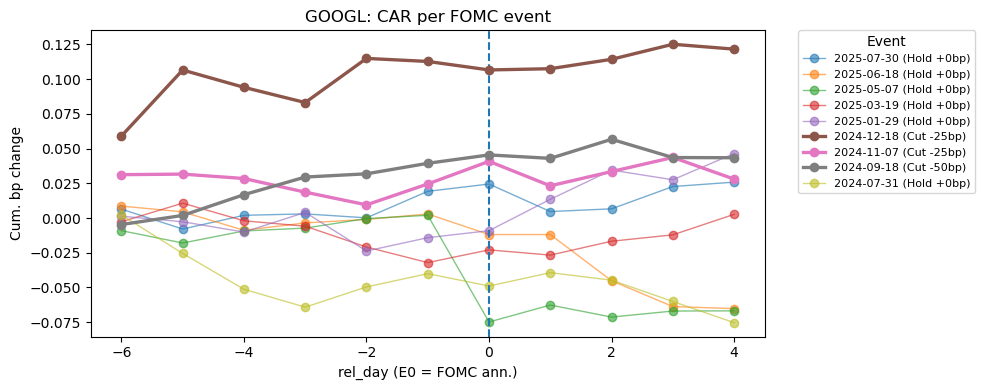

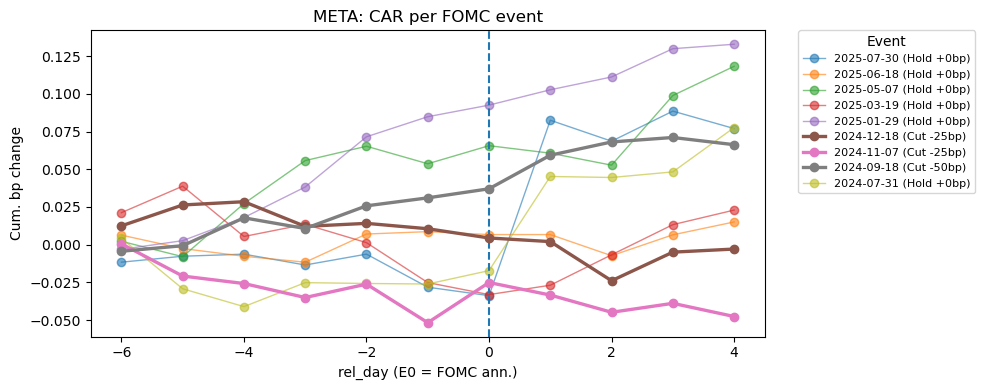

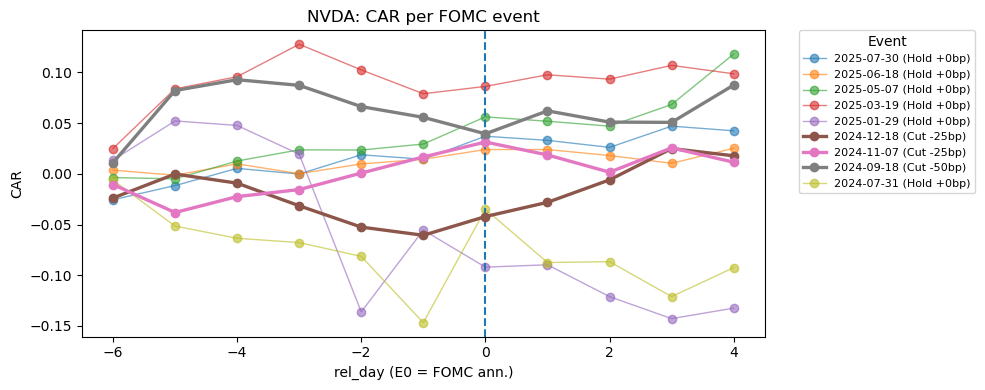

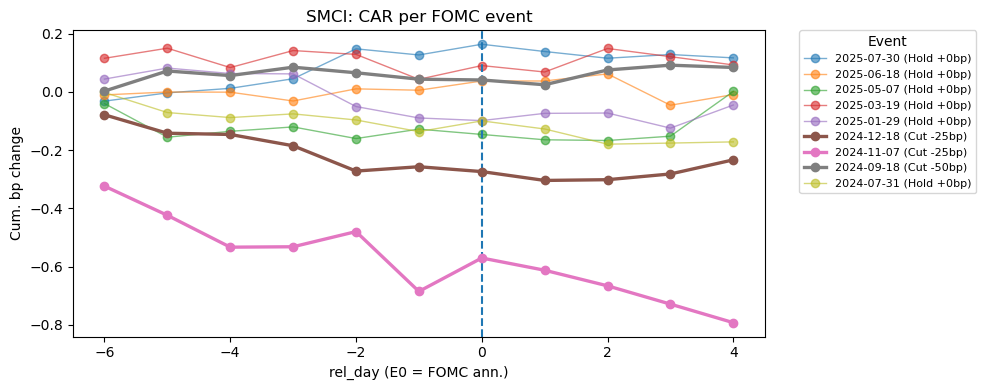

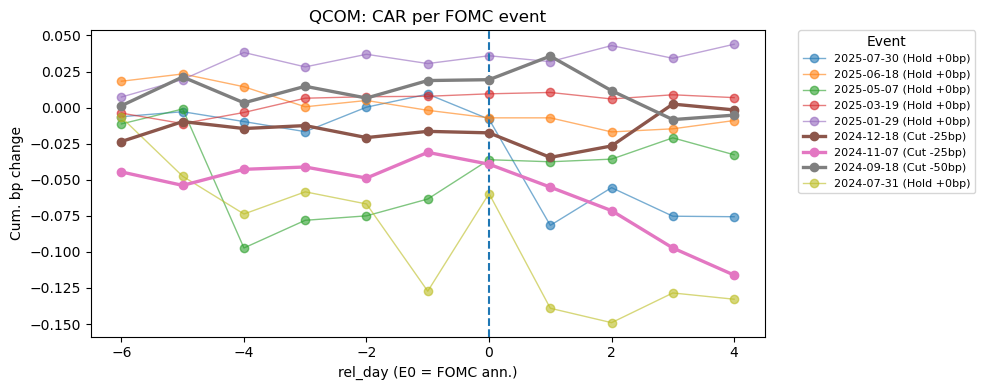

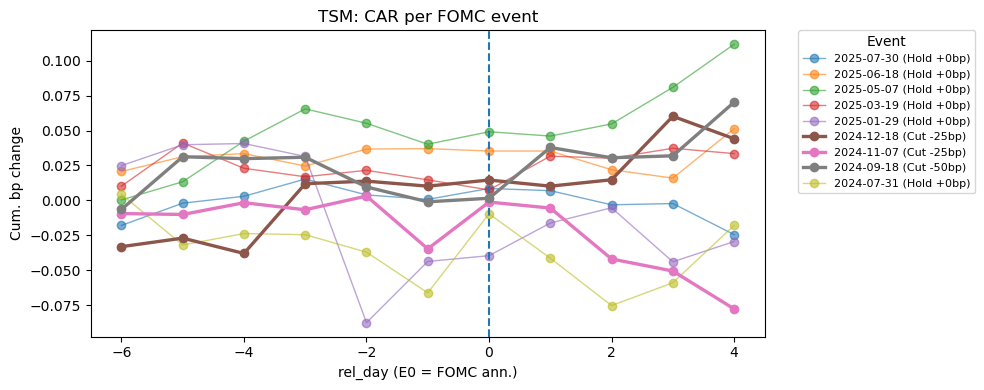

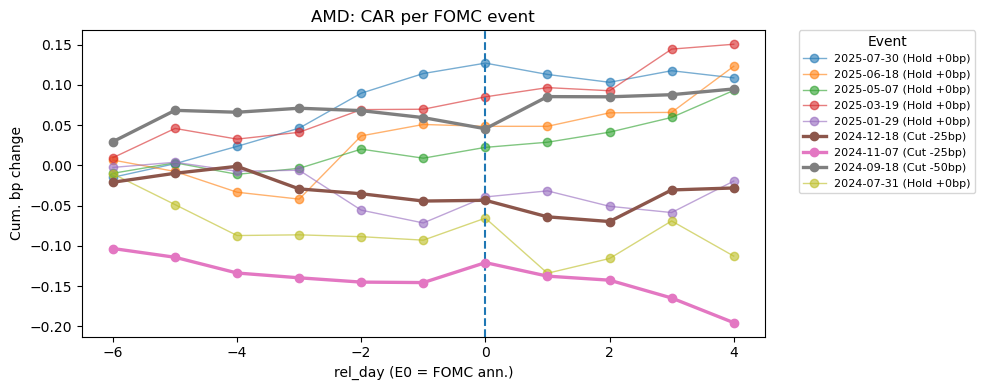

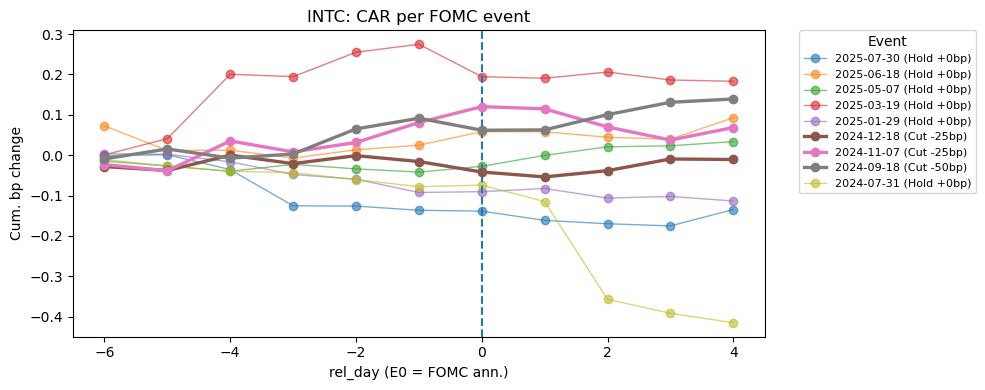

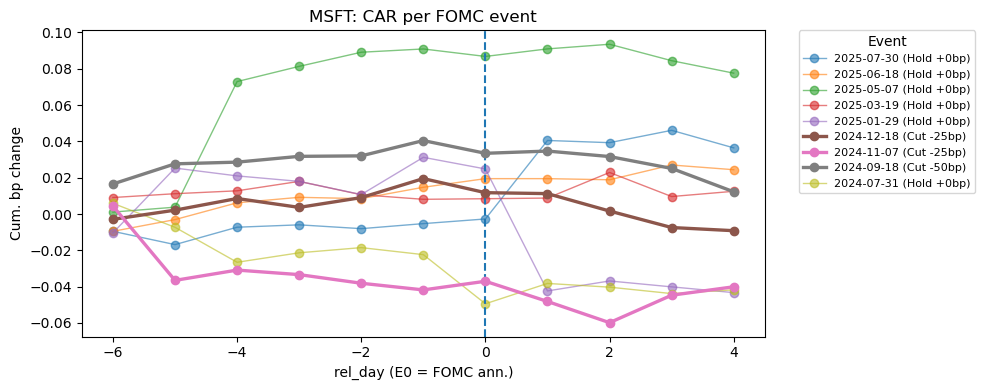

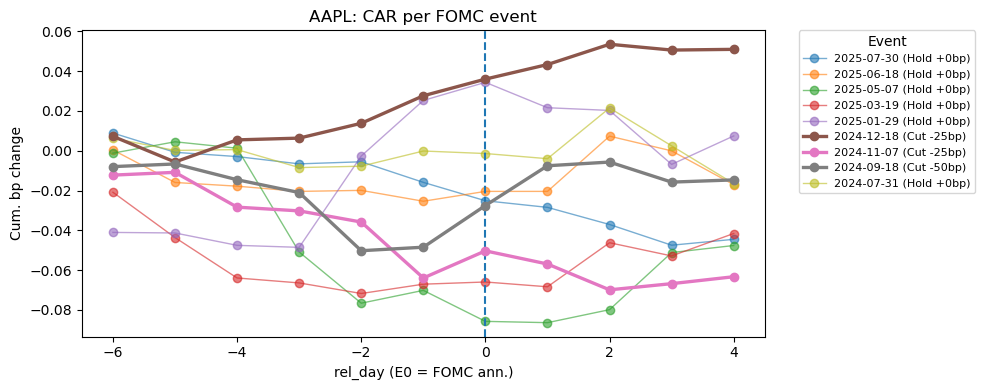

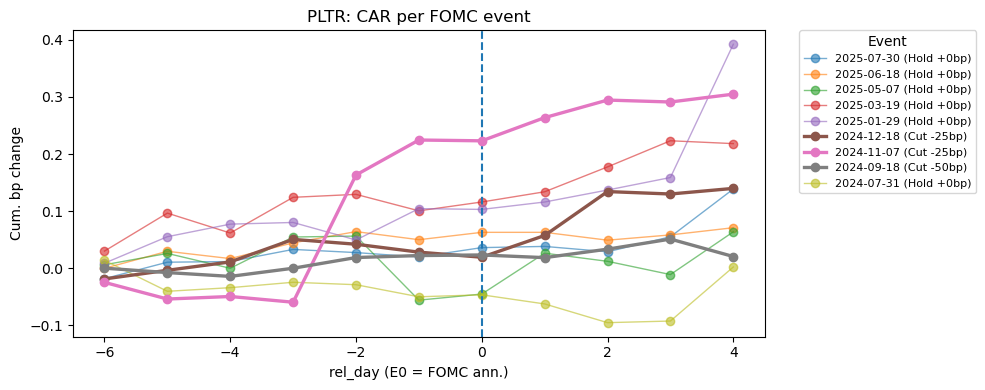

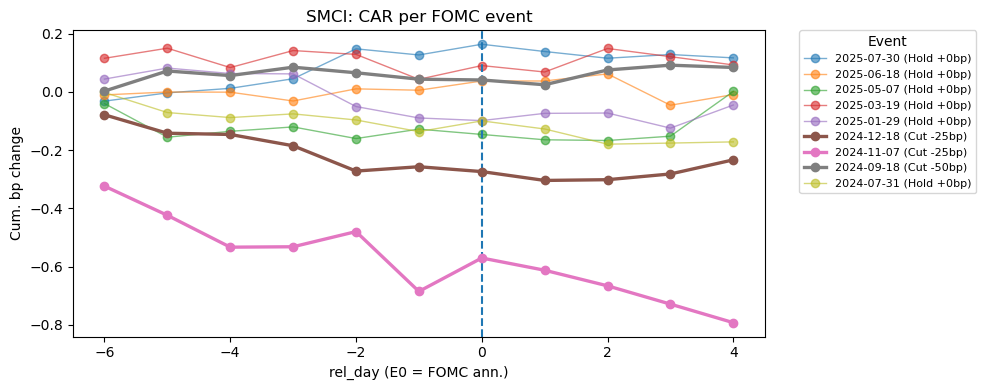

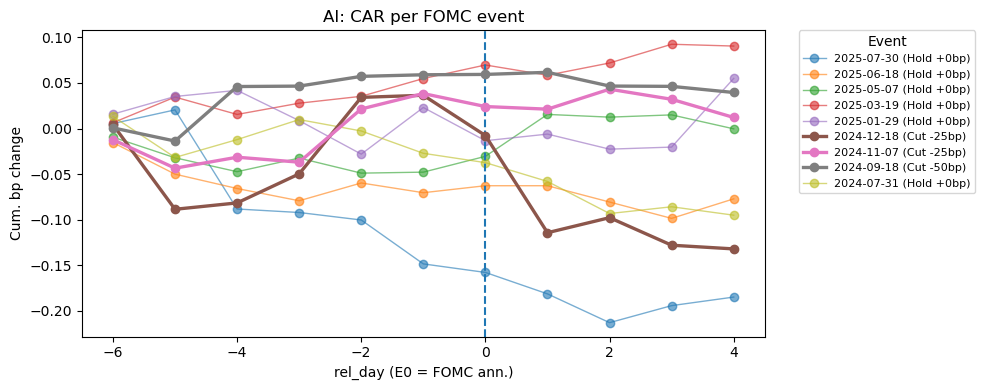

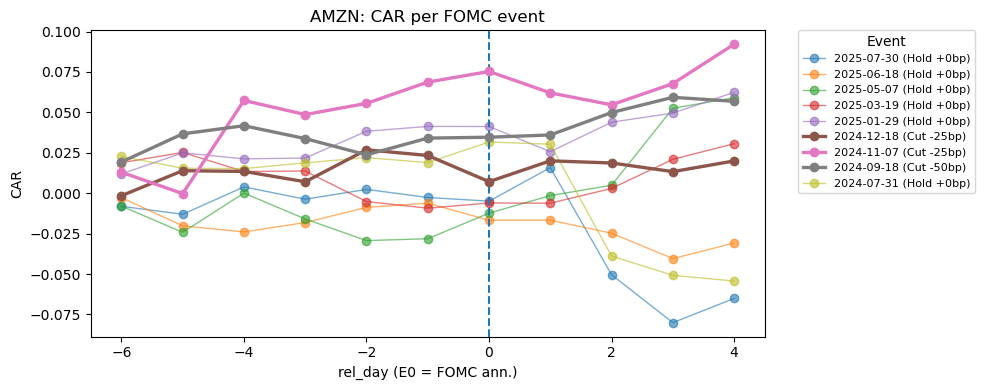

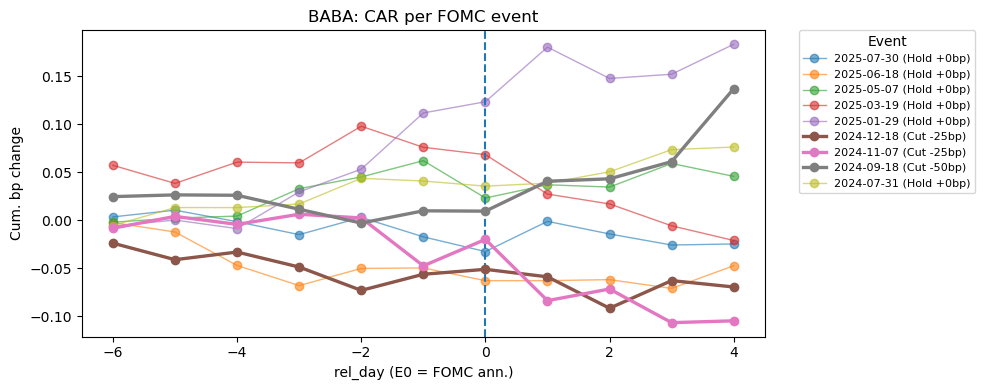

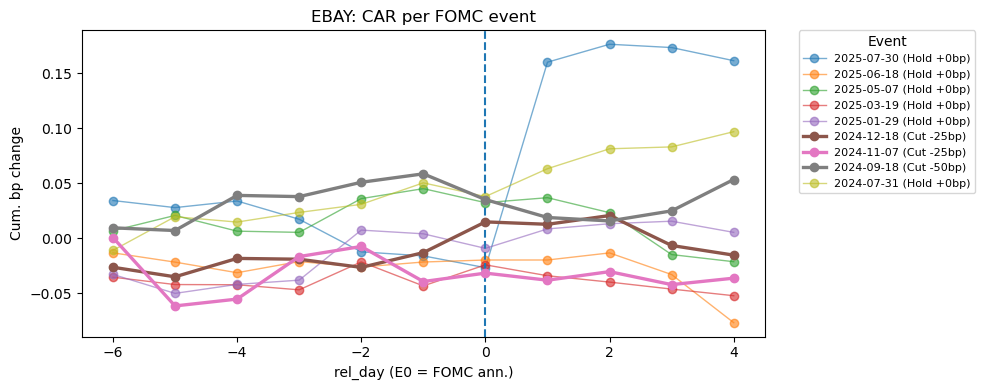

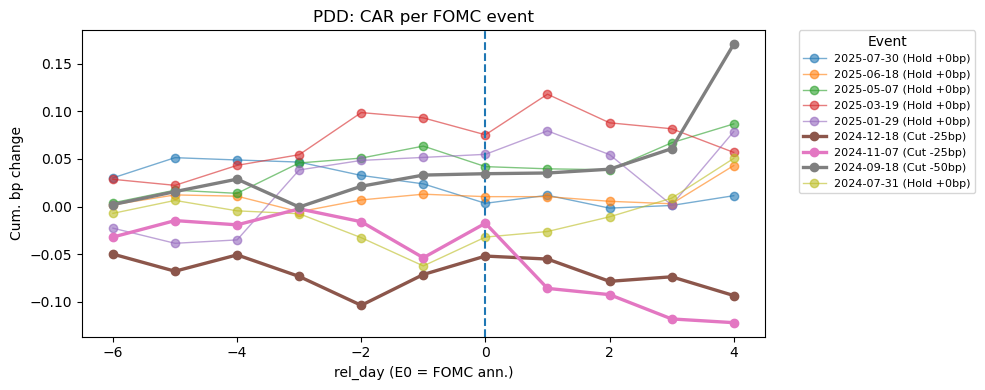

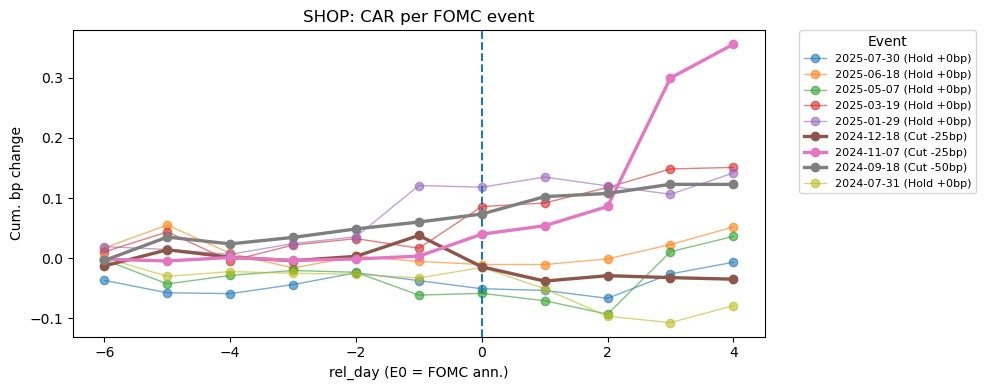

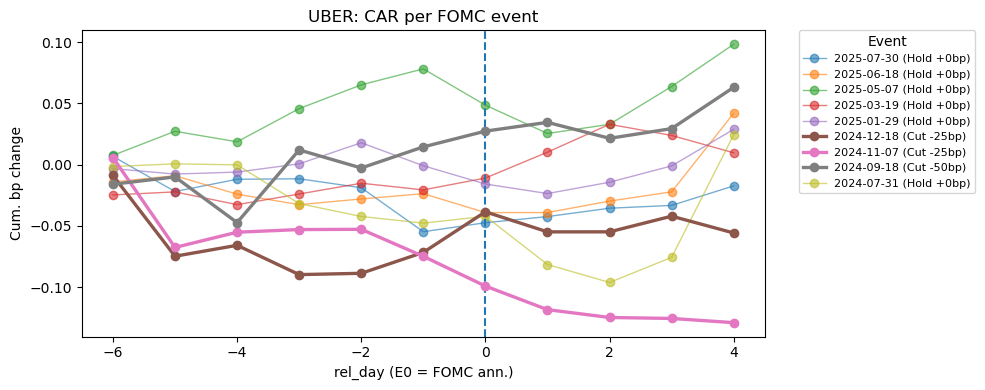

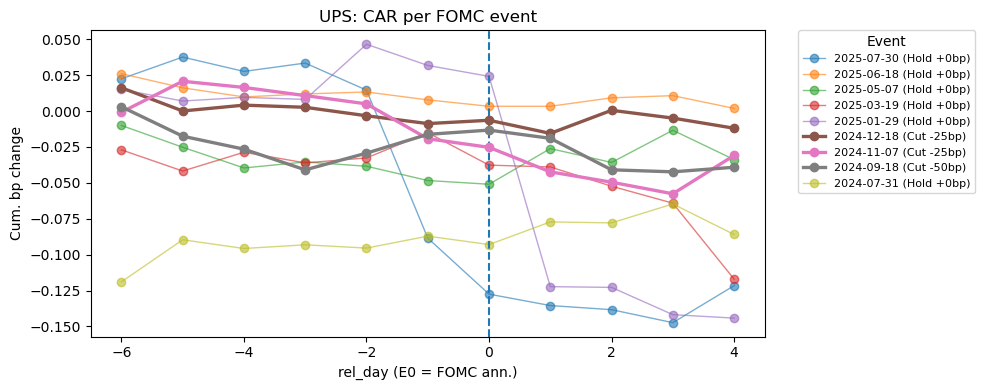

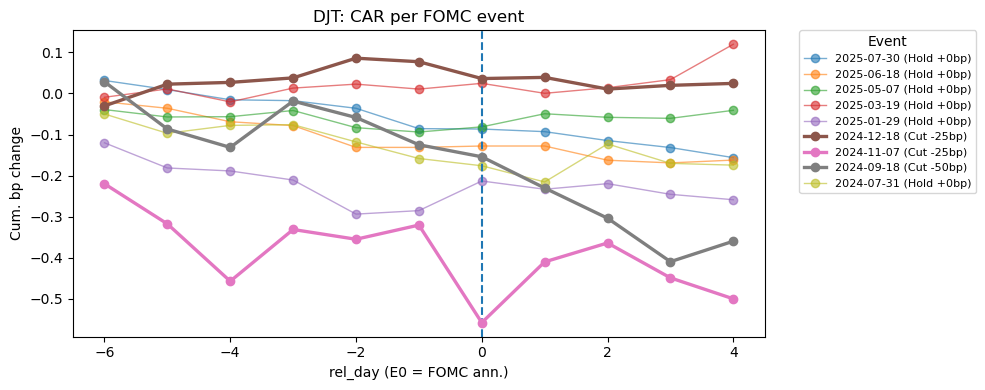

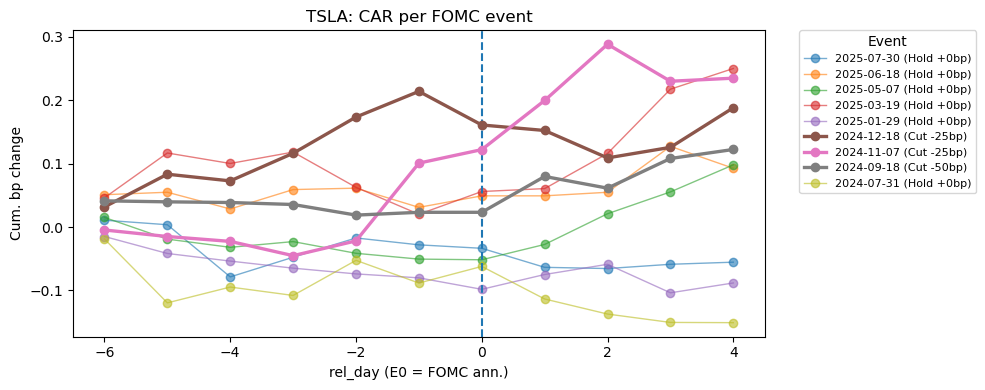

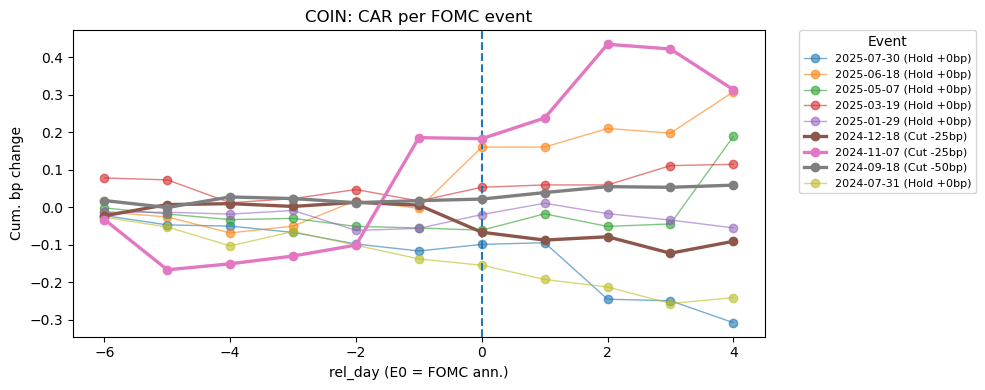

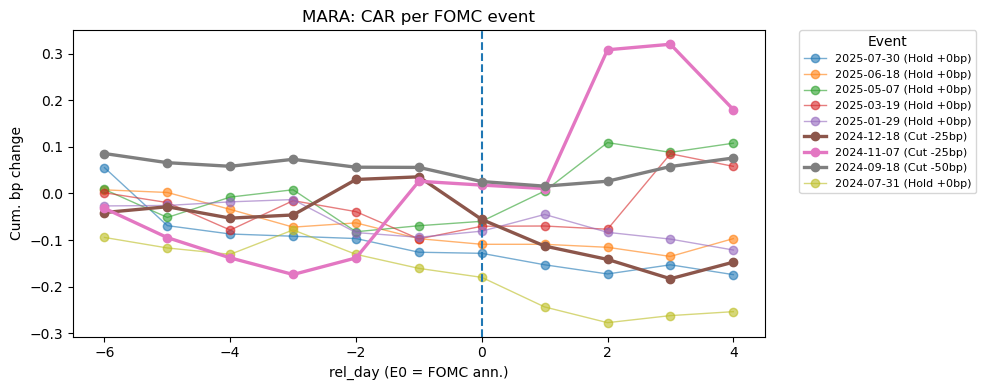

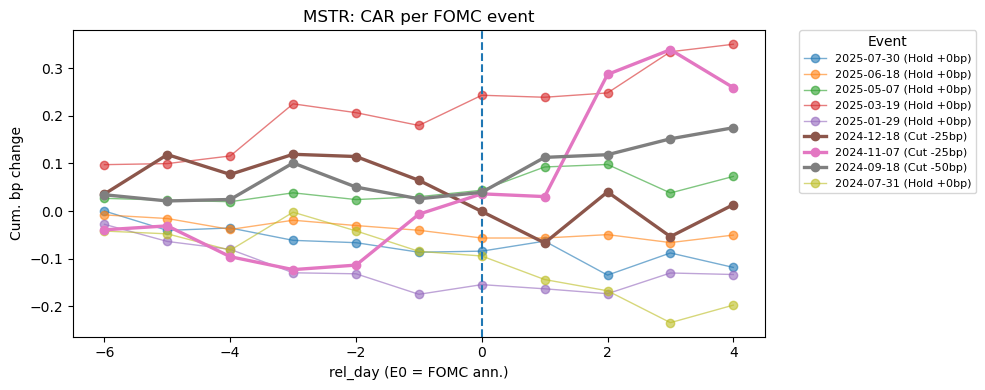

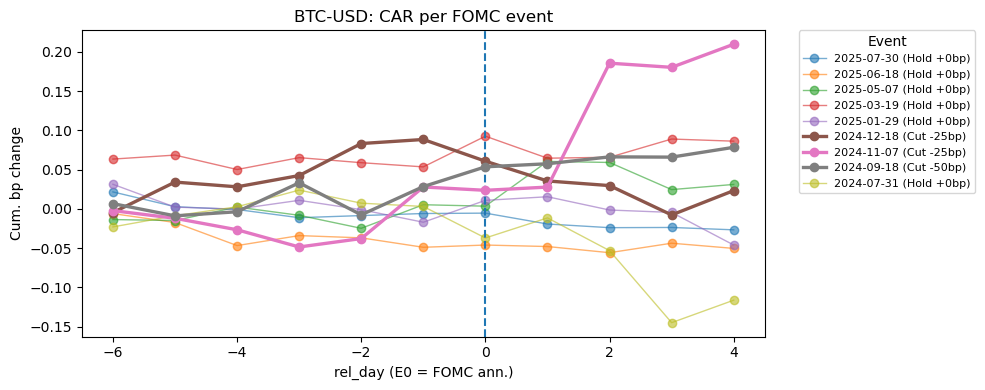

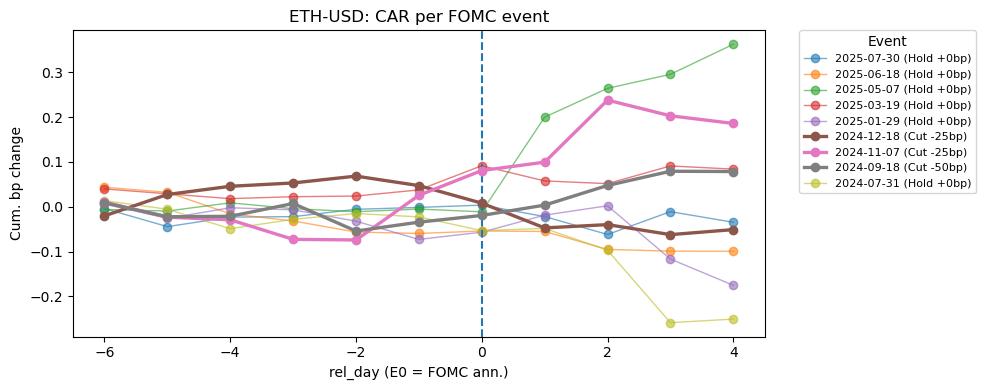

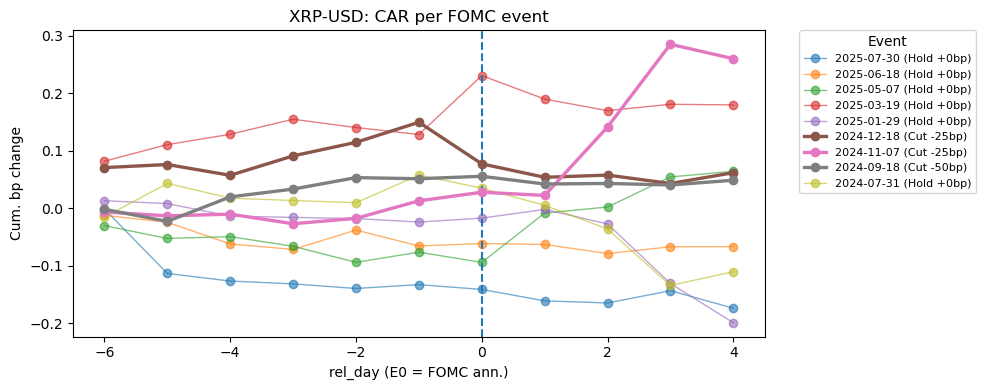

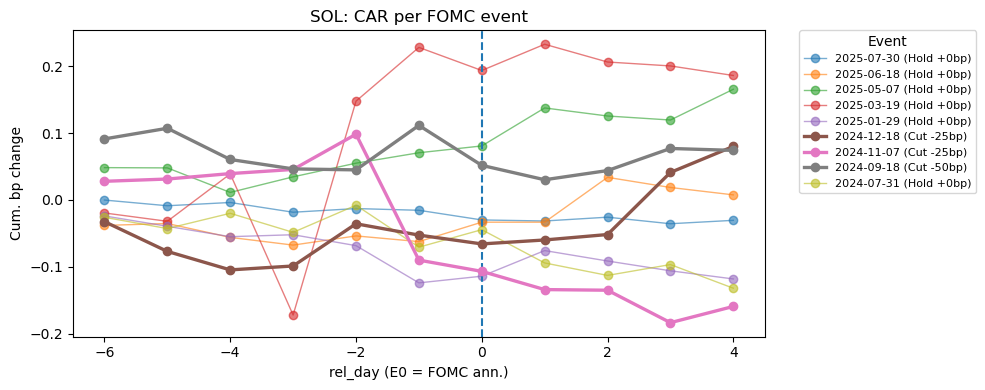

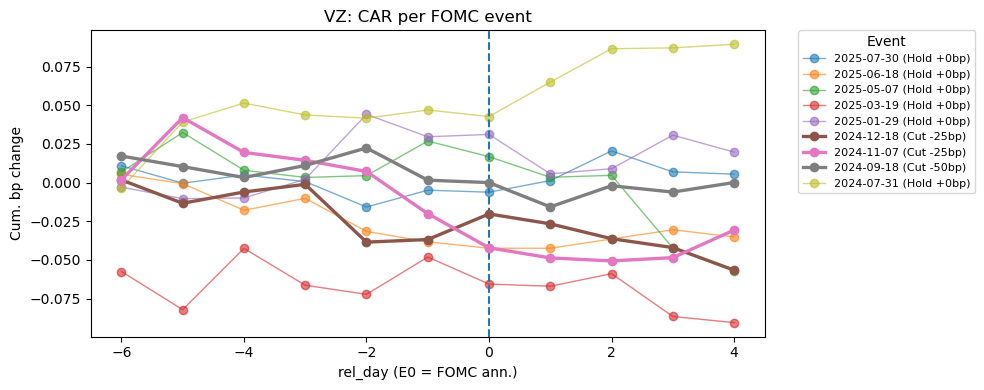

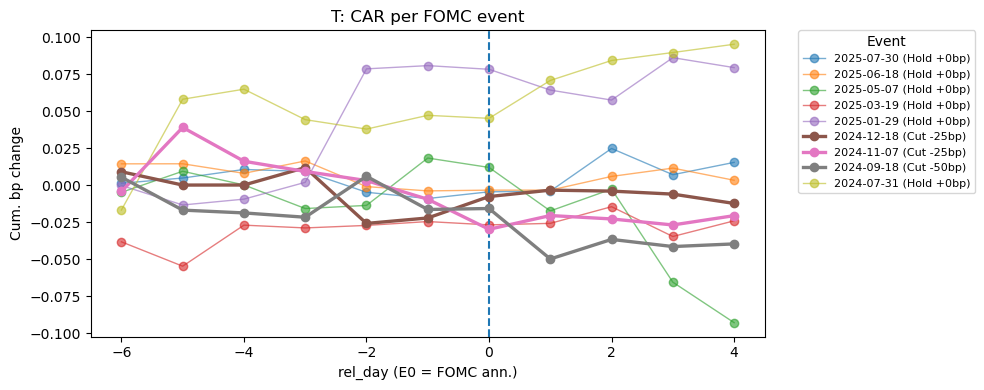

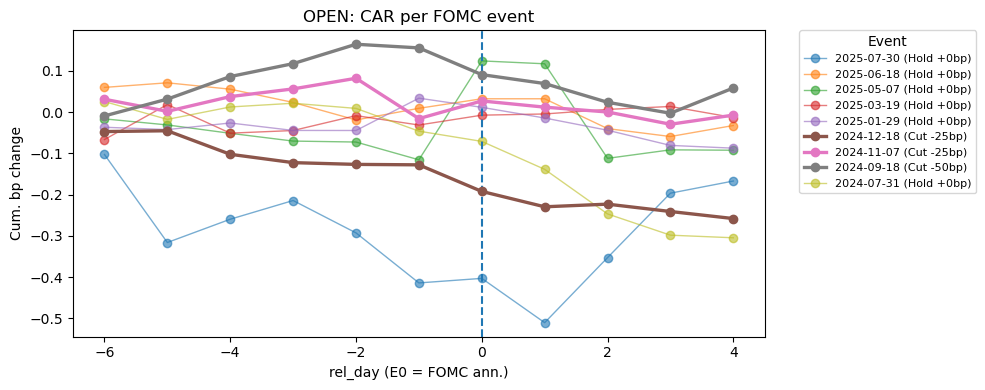

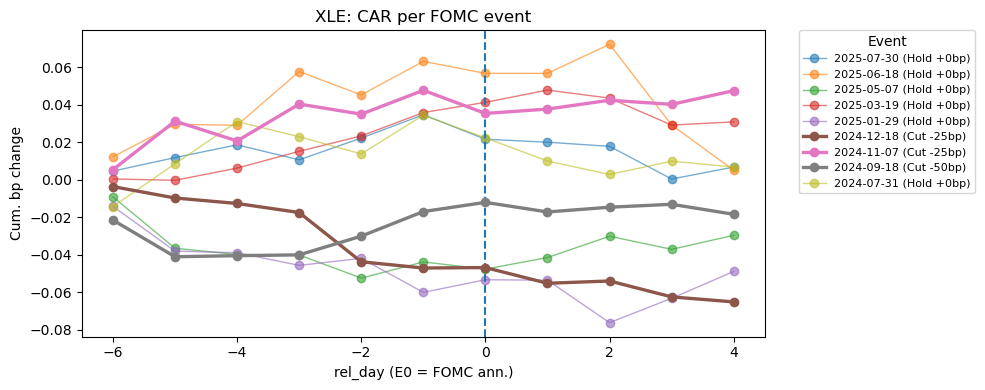

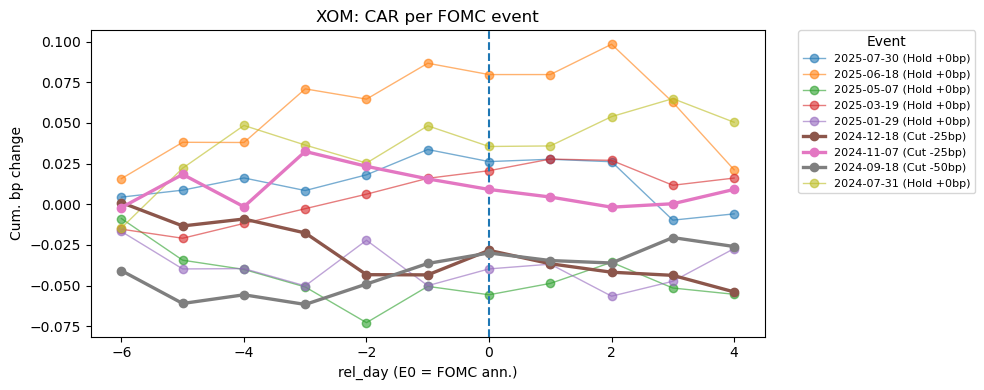

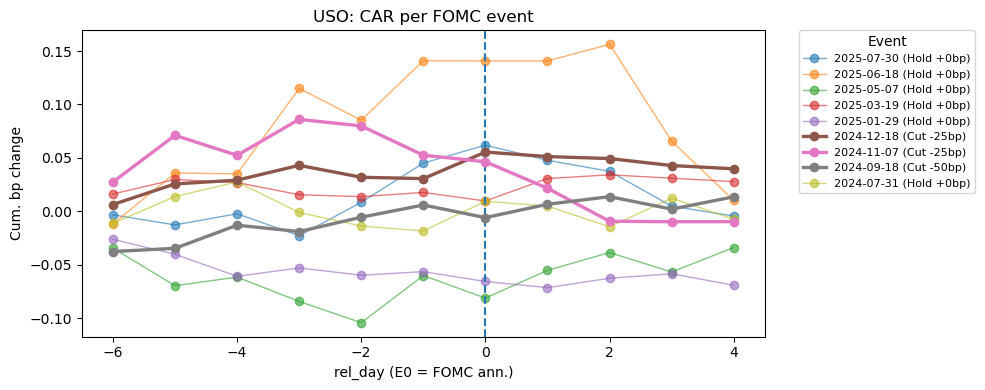

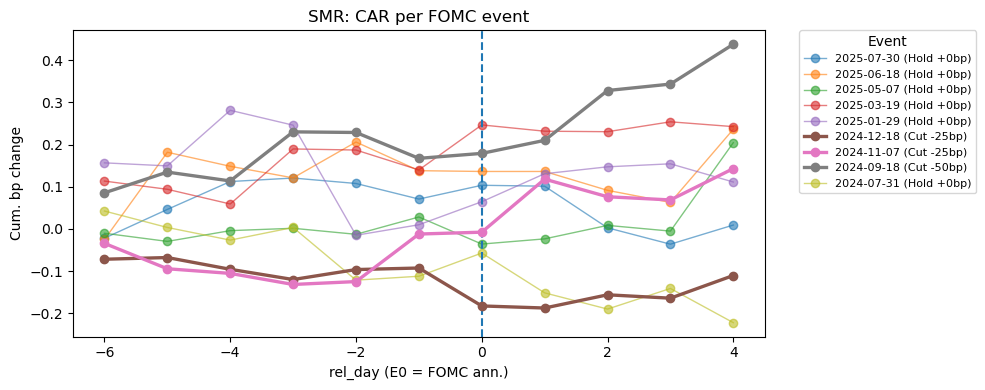

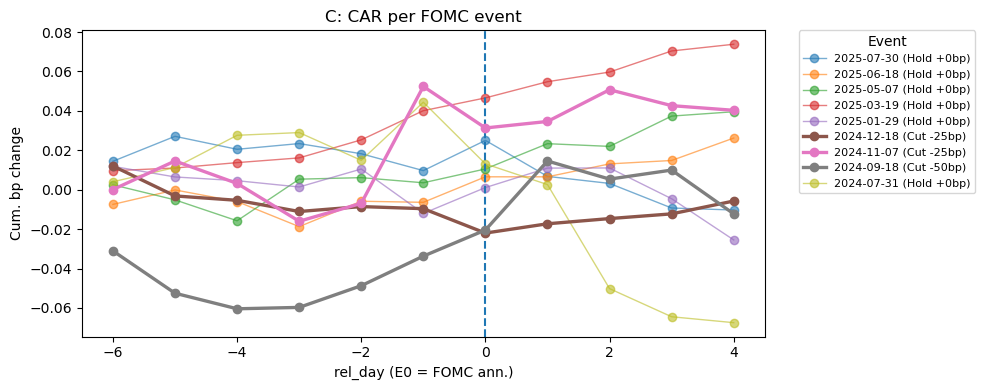

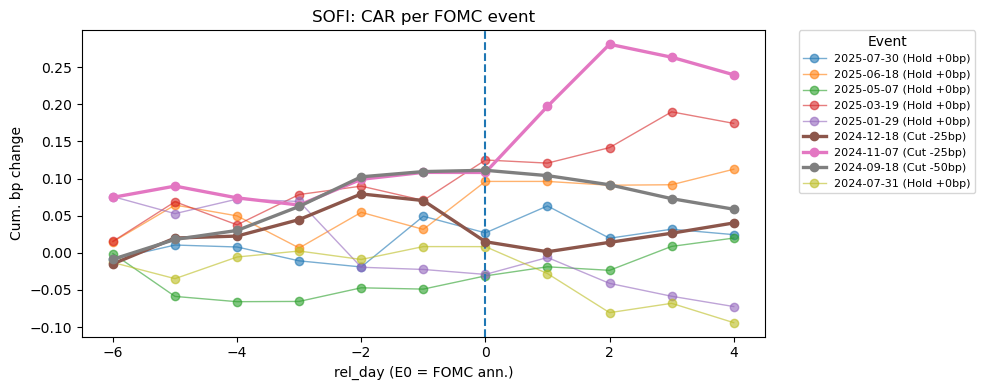

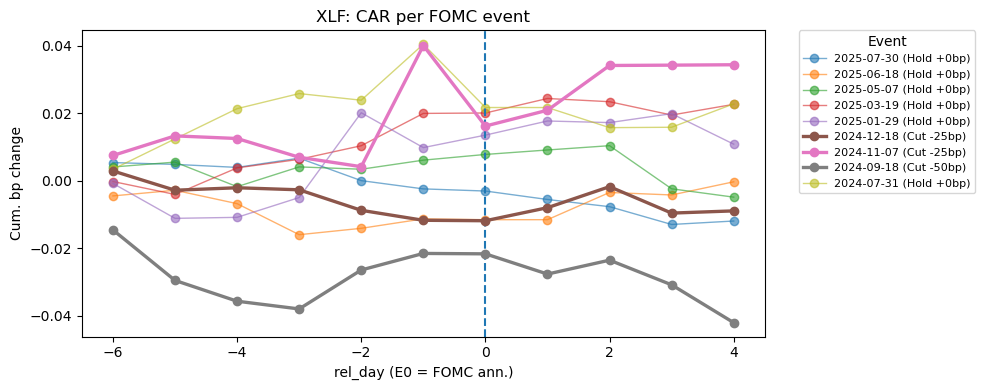

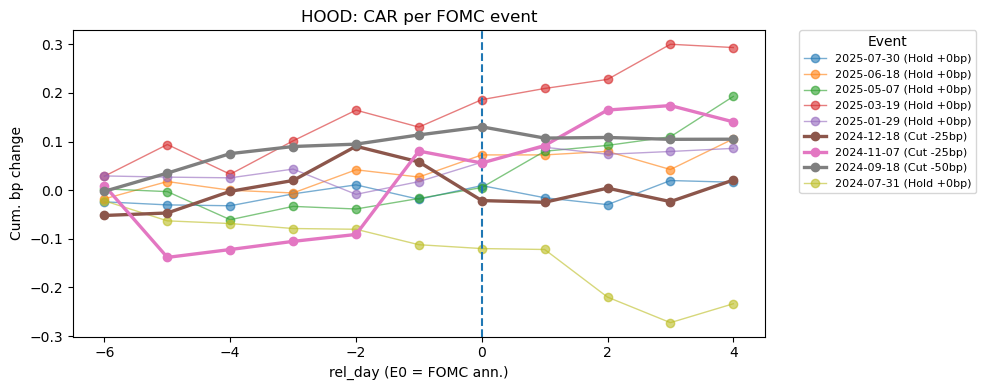

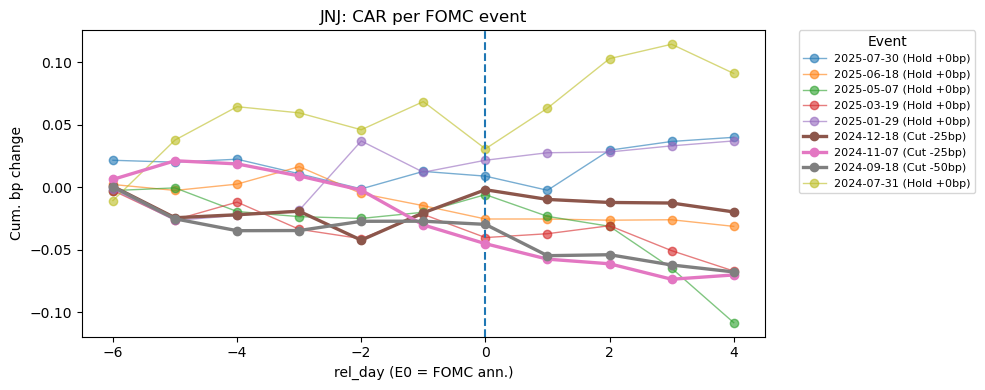

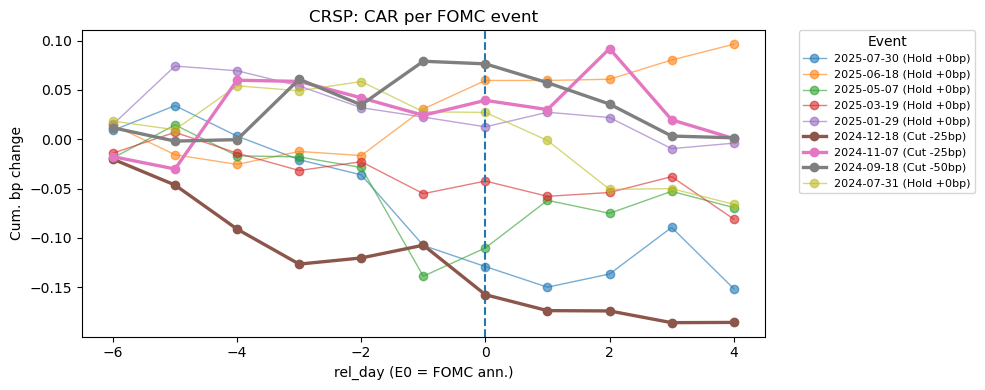

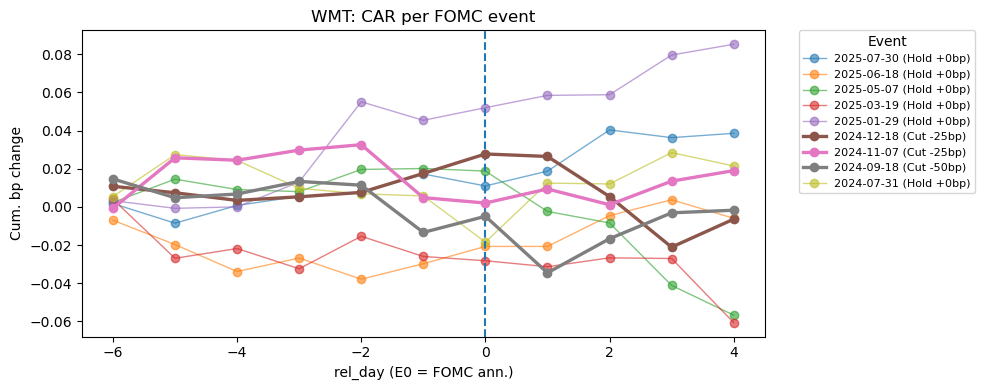

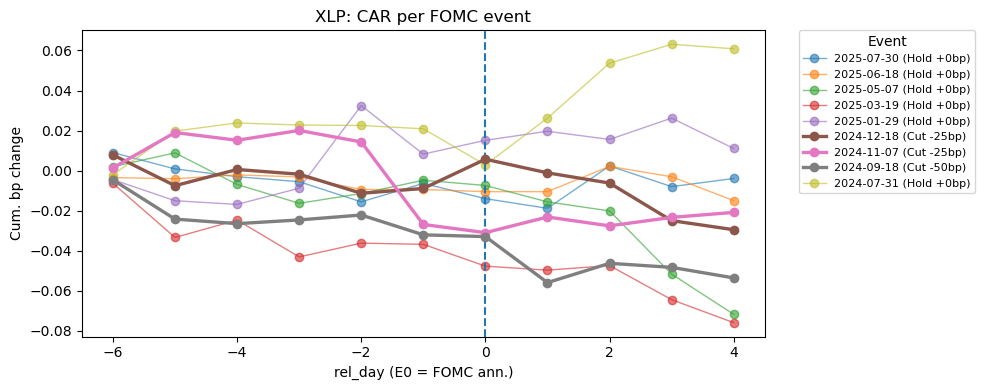

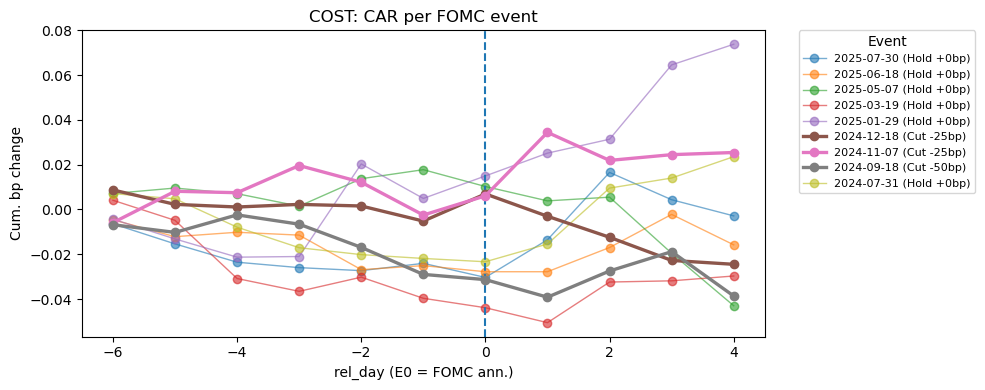

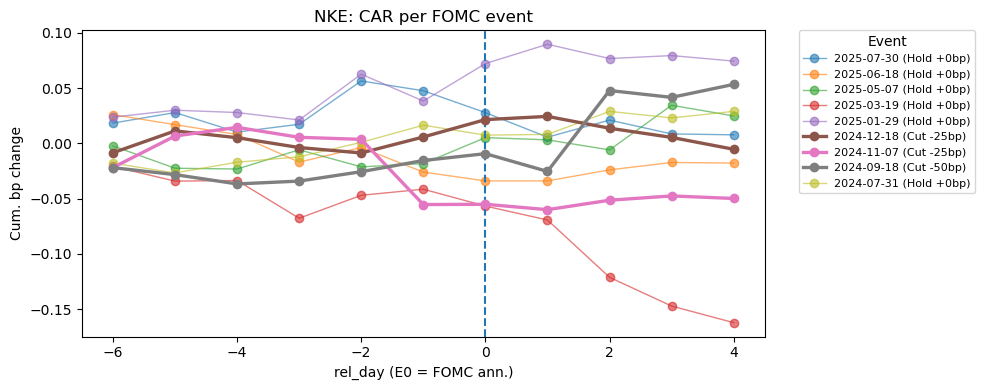

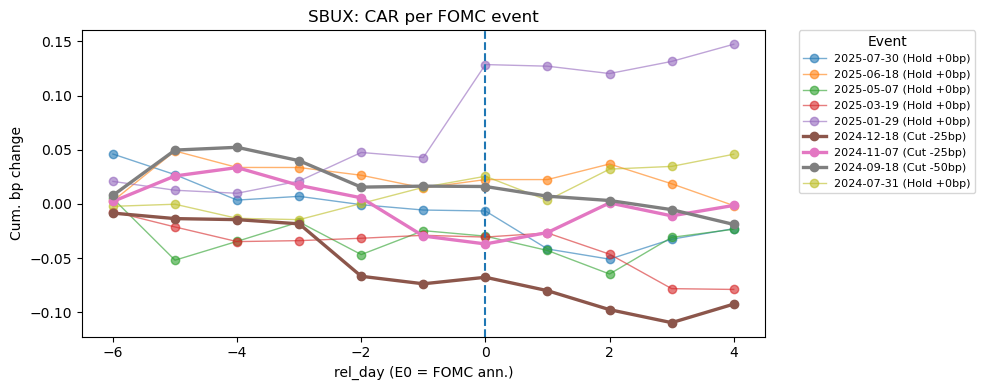

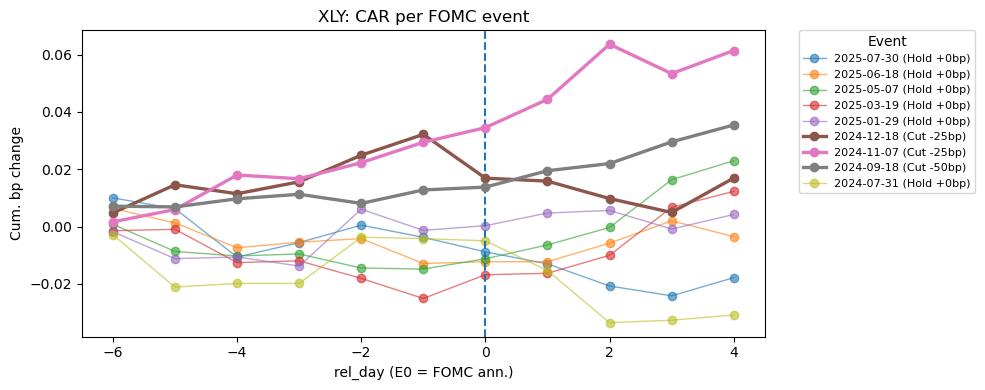

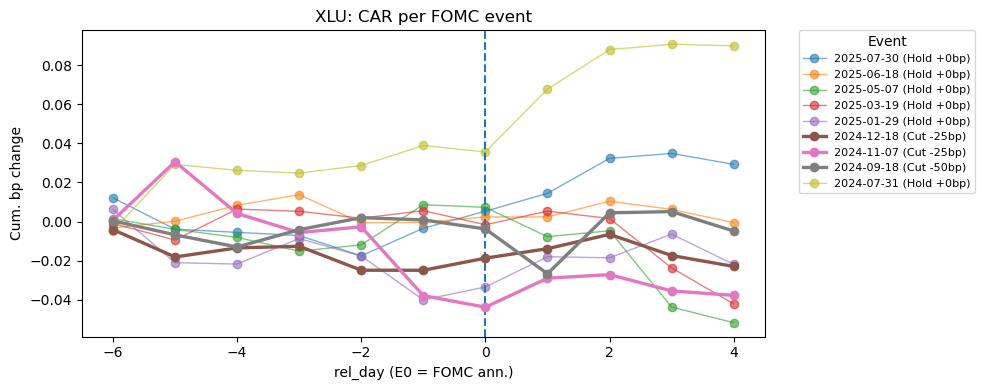

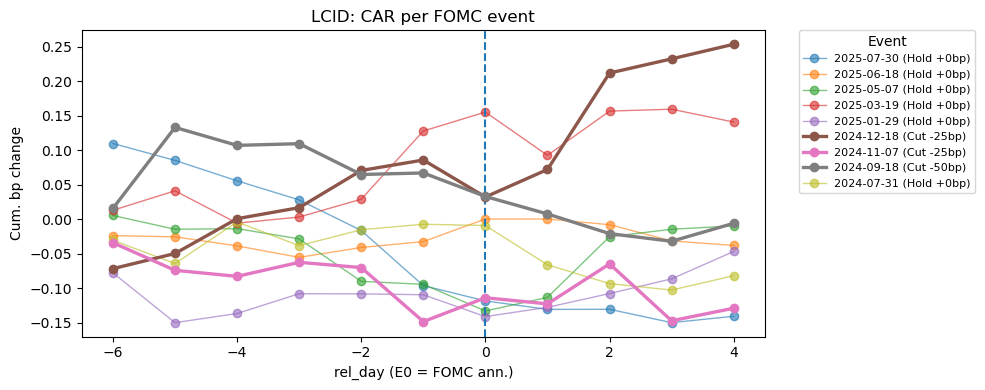

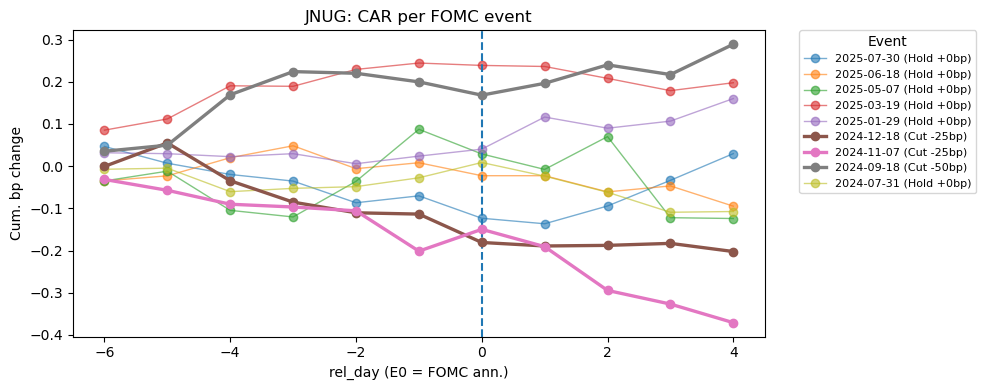

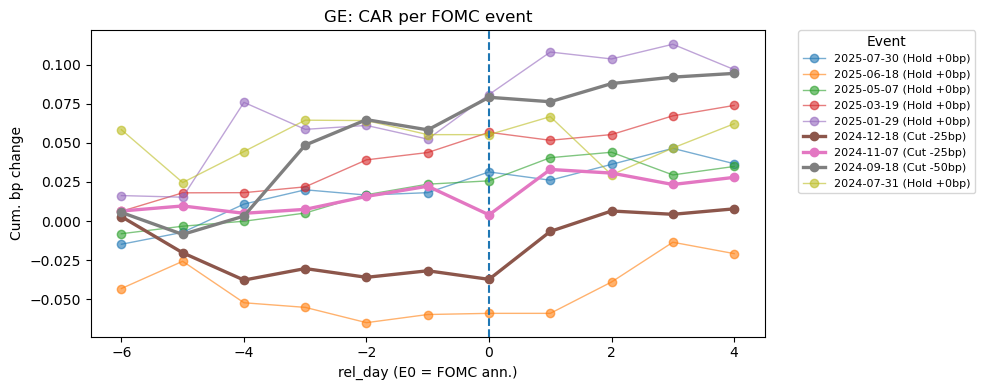

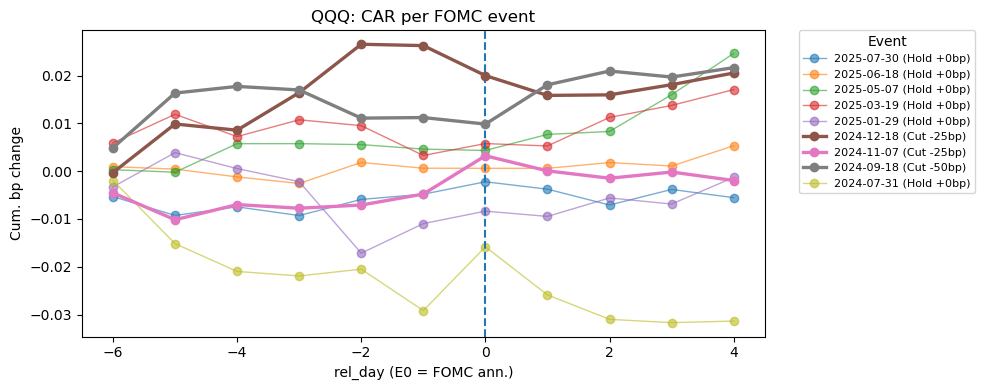

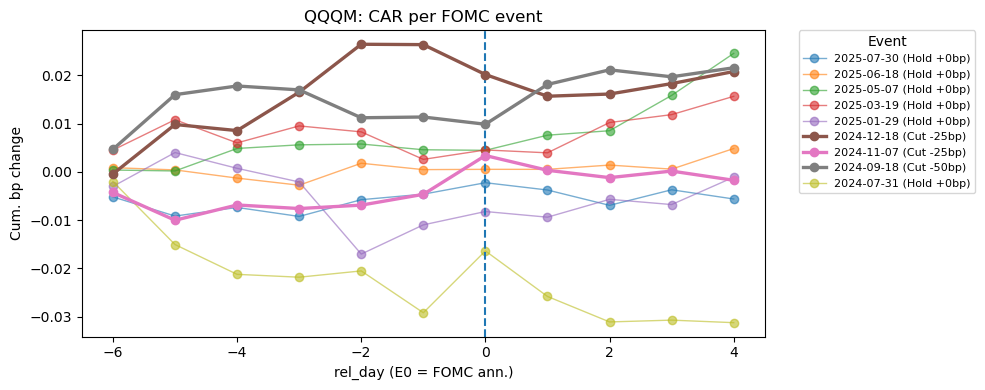

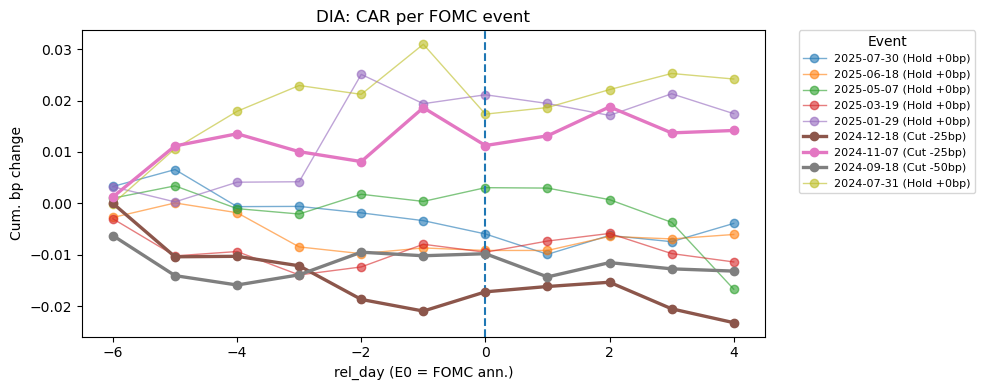

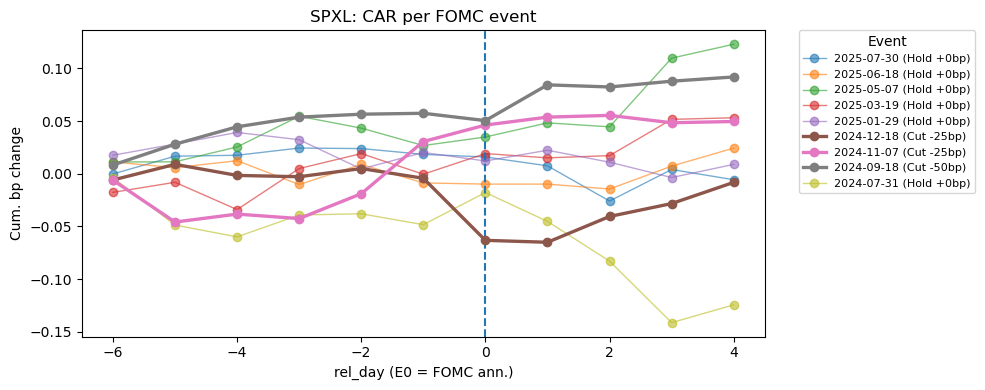

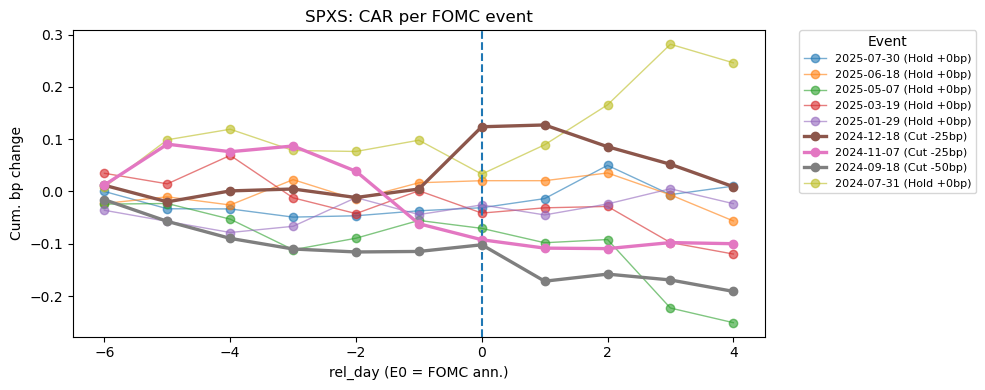

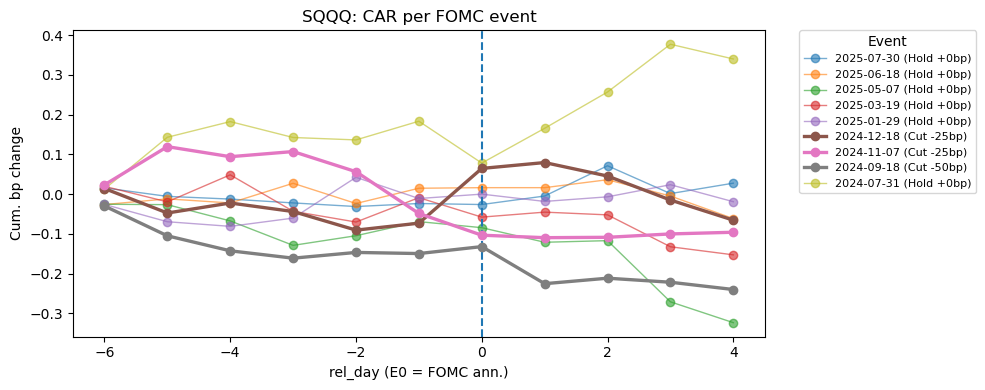

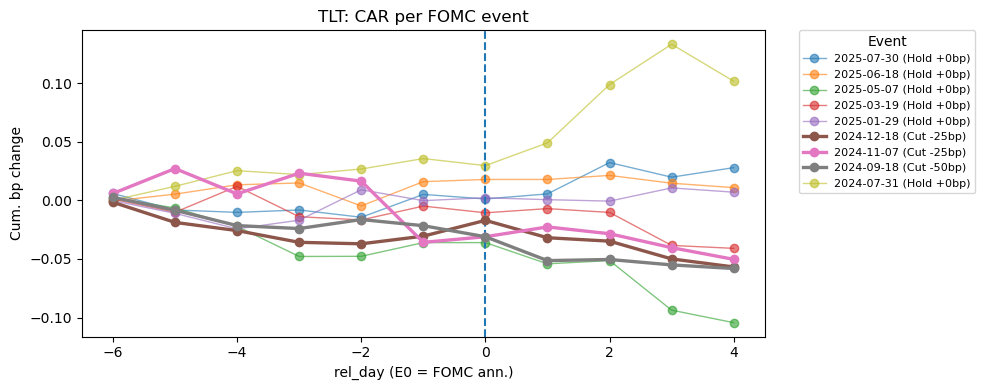

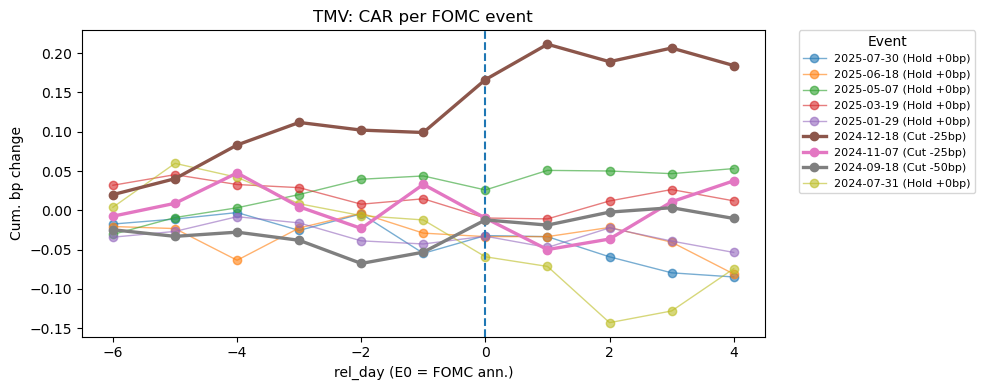

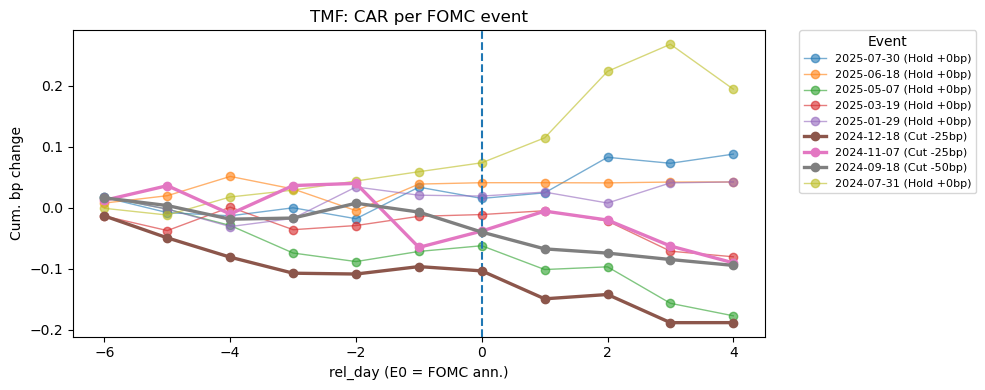

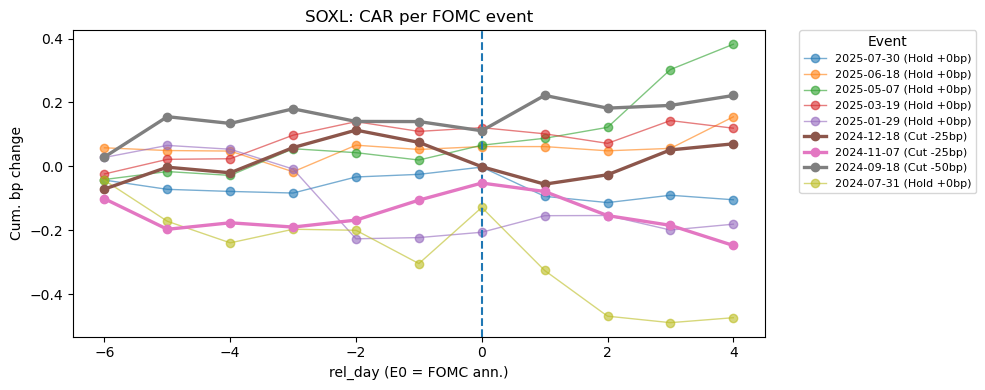

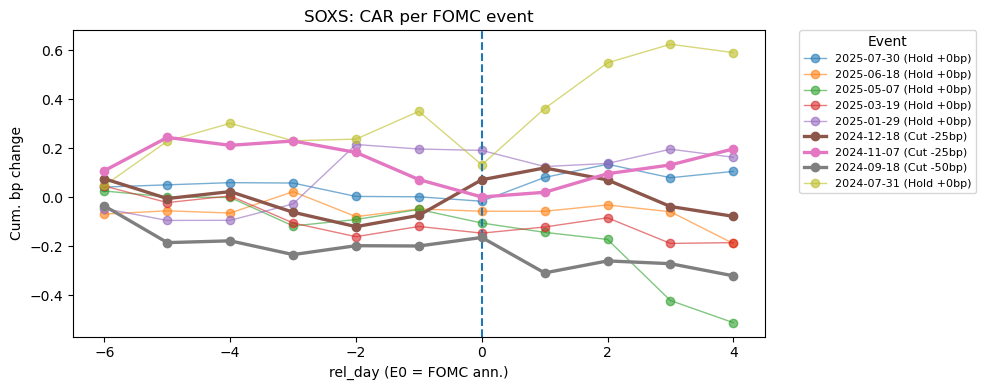

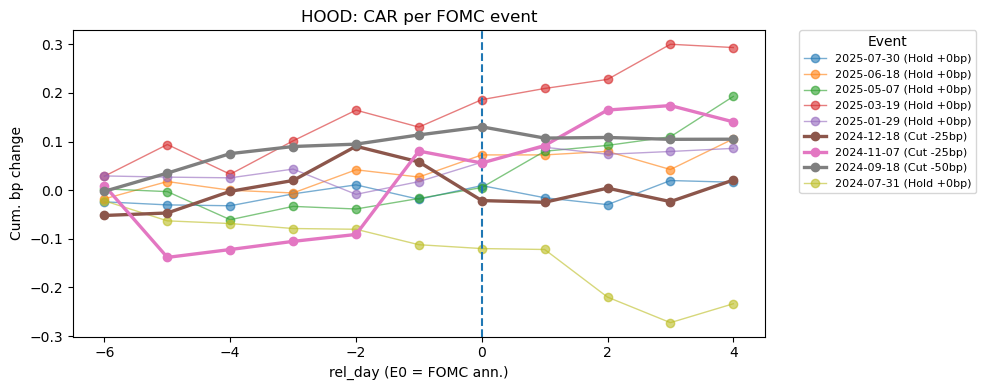

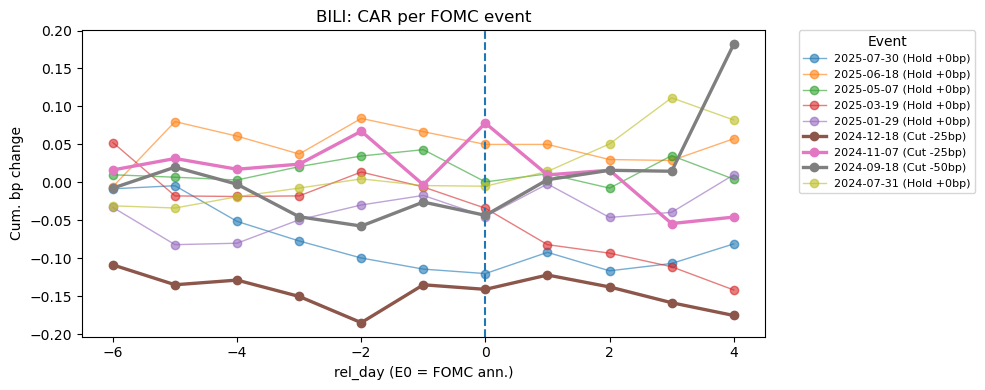

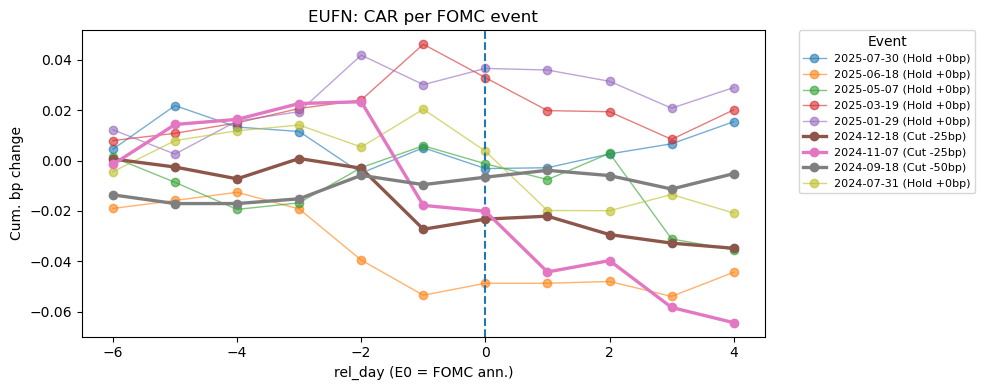

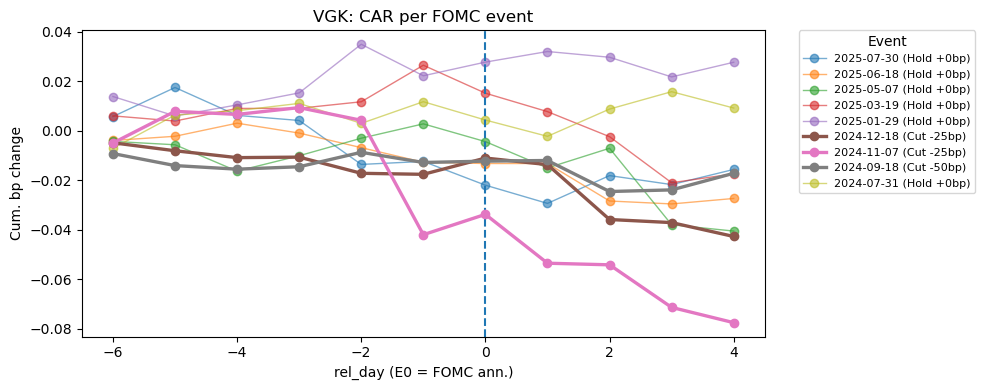

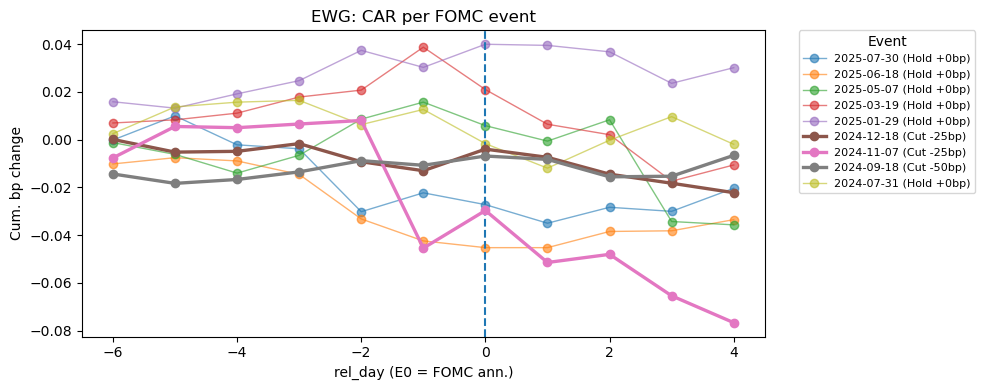

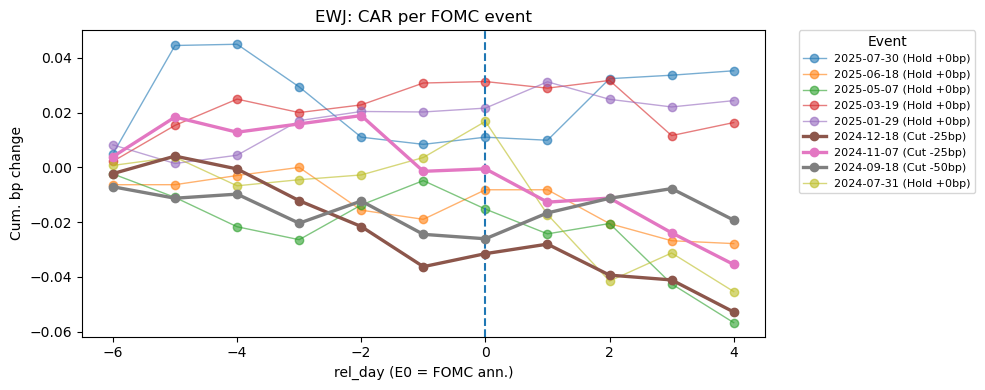

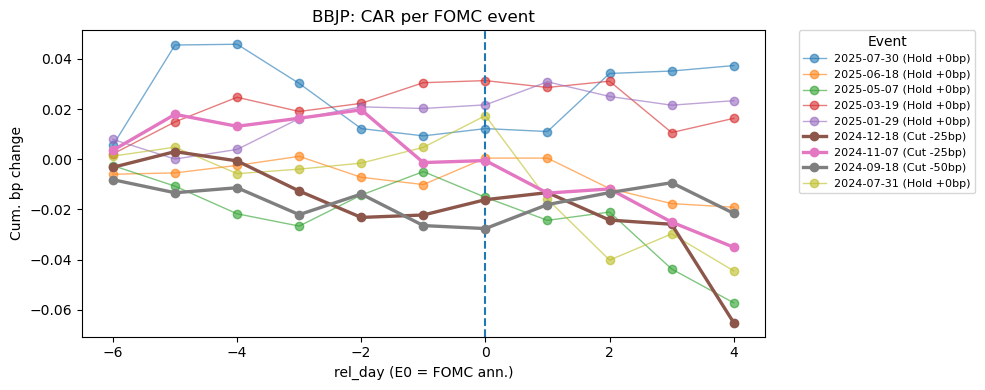

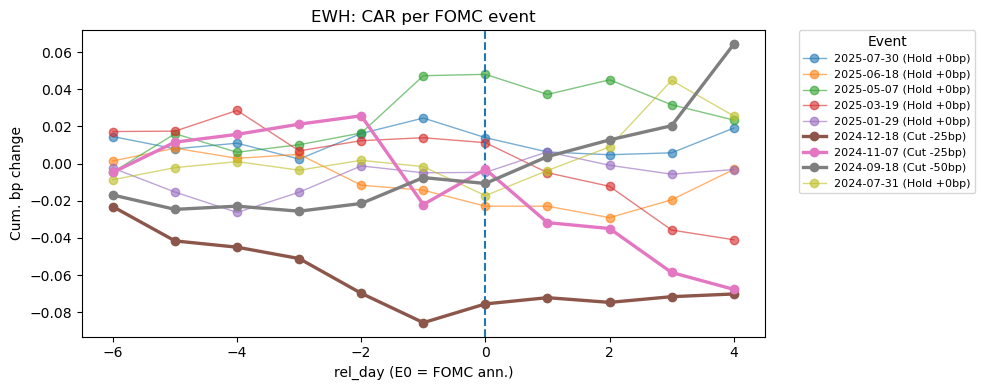

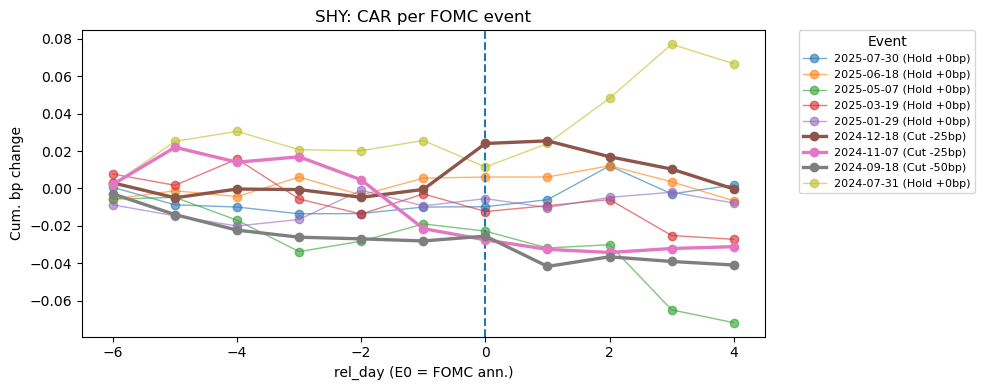

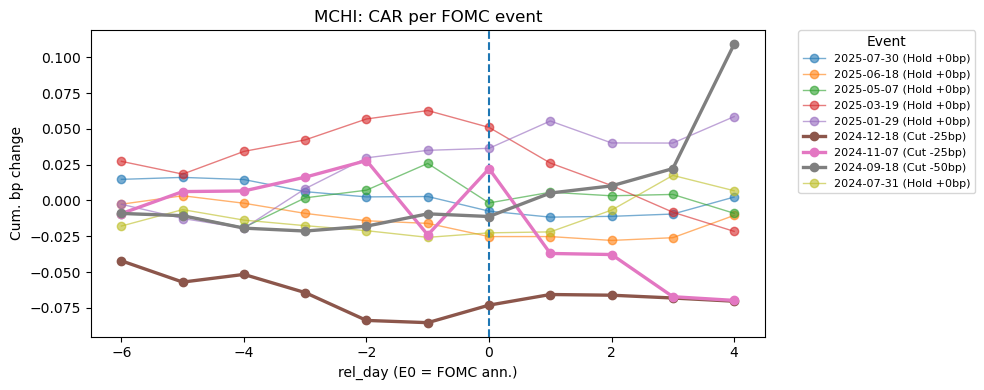

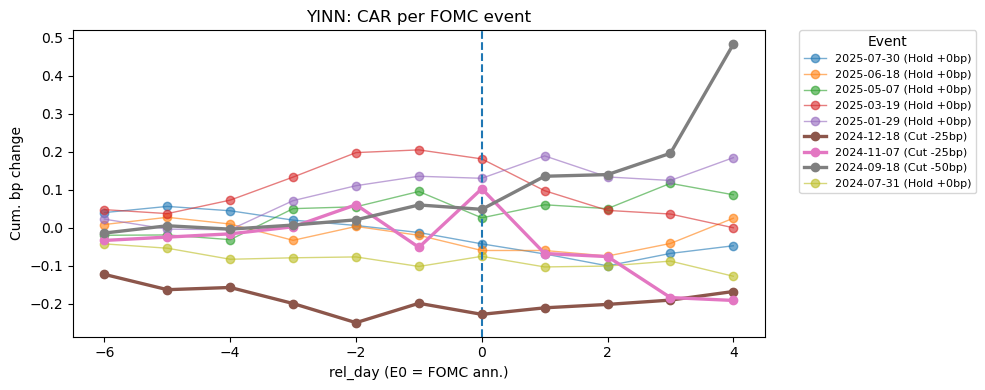

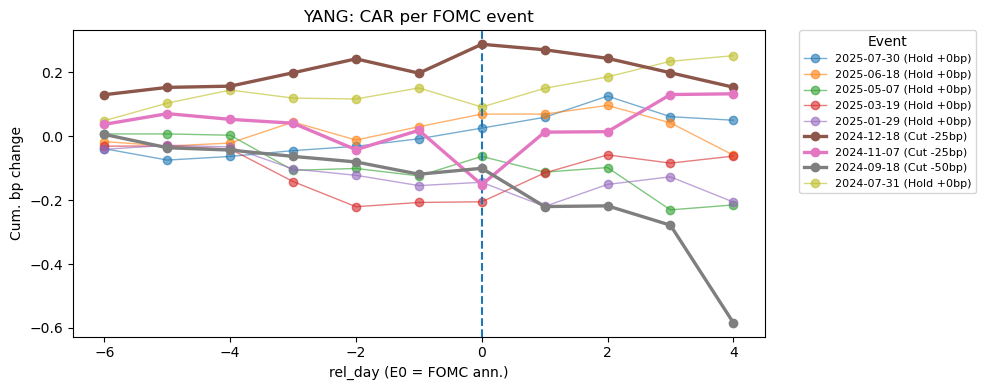

In [266]:
for t in tickers:
#     plot_each_event_overlaid(eq_curves, t, title=f"{t}: CAR per FOMC event")
    plot_each_event_overlaid(eq_curves, t, events_df=FOMC_EVENTS,
                         title=f"{t}: CAR per FOMC event")


In [270]:
eq_final_summary

CAR_-1_to_+1_avg  CAR_-3_to_+3_avg  share_sig_events(±1d_AR)
ticker                                                               
AAPL               0.0055           -0.0022                    0.1111
AI                -0.0193           -0.0131                    0.1111
AMD                0.0051            0.0338                    0.0000
AMZN               0.0044           -0.0056                    0.0000
BABA              -0.0002            0.0071                    0.0000
...                   ...               ...                       ...
XLY               -0.0000            0.0097                    0.2222
XOM                0.0076            0.0024                    0.2222
XRP-USD            0.0075            0.0185                    0.0000
YANG               0.0162           -0.0232                    0.1111
YINN              -0.0173            0.0080                    0.1111

[73 rows x 3 columns]

In [273]:
eq_final_summary.index=="WMT"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False])

In [276]:
check = (eq_results
         .query("ticker in ['TMF','SQQQ']")
         .pivot_table(index="event_date", columns="ticker", values="AR_E0"))
print(check.sort_index())


ticker          SQQQ       TMF
event_date                    
2024-07-31 -0.105332  0.014637
2024-09-18  0.017459 -0.032827
2024-11-07 -0.054649  0.026797
2024-12-18  0.137748 -0.007061
2025-01-29  0.011026 -0.001427
2025-03-19 -0.048946  0.002910
2025-05-07 -0.015231  0.009356
2025-06-18  0.001486  0.002284
2025-07-30 -0.002593 -0.018493


In [277]:
# tickers of interest
tickers = ["YINN","BBJP","EUFN"]

# 1) Mean AR/CAR by decision bucket
sub = eq_results[eq_results["ticker"].isin(tickers)].copy()
by_decision = (sub.groupby(["ticker","decision"])
                 [["AR_E0","CAR_-1_to_+1","CAR_-3_to_+3"]]
                 .mean().round(4))

# 2) Hit rate: share of events with CAR(+3) > 0, by decision
def car_at(curves, ticker, event_date, rel=3):
    key = (ticker, str(pd.to_datetime(event_date).date()))
    s = curves.get(key)
    return None if (s is None or rel not in s.index) else float(s.loc[rel])

sub["CAR_+3"] = sub.apply(lambda r: car_at(eq_curves, r["ticker"], r["event_date"], 3), axis=1)
hit_rate = (sub.assign(up=lambda df: df["CAR_+3"]>0)
              .groupby(["ticker","decision"])["up"].mean()
              .rename("hit_rate_>0@+3"))


In [278]:
hit_rate

ticker  decision
BBJP    Cut         0.000000
        Hold        0.500000
EUFN    Cut         0.000000
        Hold        0.500000
YINN    Cut         0.333333
        Hold        0.500000
Name: hit_rate_>0@+3, dtype: float64